<a href="https://colab.research.google.com/github/hardiksiloiya/GANs/blob/main/CycleGAN_with_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install tensorflow_addons
!gdown --id 1tCKRDgng0XxhbEsLncsatHXMupD_goHy
!gdown --id 19_bil_5hs1ERHOILF7DtmziMXqPBfJN3

Downloading...
From: https://drive.google.com/uc?id=1tCKRDgng0XxhbEsLncsatHXMupD_goHy
To: /content/scene.rar
63.0MB [00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=19_bil_5hs1ERHOILF7DtmziMXqPBfJN3
To: /content/Claude_Monet.rar
26.0MB [00:00, 113MB/s] 


In [3]:
!pip install unrar
!unrar x scene.rar
!unrar x Claude_Monet.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from scene.rar

Creating    scene                                                     OK
Extracting  scene/00000113.jpg                                             0%  OK 
Extracting  scene/00000113_(2).jpg                                         0%  OK 
Extracting  scene/00000113_(3).jpg                                         0%  OK 
Extracting  scene/00000113_(4).jpg                                         1%  OK 
Extracting  scene/00000113_(5).jpg                                         1%  OK 
Extracting  scene/00000113_(6).jpg                                         1%  OK 
Extracting  scene/00000114.jpg                                             1%  OK 
Extracting  scene/00000114_(2).jpg                                         1%  OK 
Extracting  scene/00000114_(3).jpg                                         2%  OK 
Ext

In [19]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.layers import Activation,Concatenate,Conv2D,UpSampling2D,Dense,Flatten,Input,add
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

glosses=[]
dlosses=[]
def batch(temp, n=1):
    l = len(temp)
    for ndx in range(0, l, n):
        yield temp[ndx:min(ndx + n, l)]

def data_loader(x1,x2):
    random.shuffle(x1)
    random.shuffle(x2)
    
    app=batch(x1,5)
    bnn=batch(x2,5)
    res=zip(app,bnn)
    return list(res)

def train():
  valid=np.ones((5,8,8,1))
  fake=np.zeros((5,8,8,1))

  for i in range(100):
    print("epoch ",i)
    for [imgea,imgeb] in data_loader(apples,bananas):
        tempa=[]
        tempb=[]
        if min(len(imgea),len(imgeb))<5:
          break
        for j in range(min(len(imgea),len(imgeb))):
            sample1=cv2.imread(imgea[j])
            sample2=cv2.imread(imgeb[j])
            sample1=cv2.resize(sample1,dsize=(256,256),interpolation=cv2.INTER_CUBIC)
            sample2=cv2.resize(sample1,dsize=(256,256),interpolation=cv2.INTER_CUBIC)
            #sample1=cv2.cvtColor(sample1,cv2.COLOR_BGR2RGB)
            #sample2=cv2.cvtColor(sample2,cv2.COLOR_BGR2RGB)
            tempa.append(sample1)
            tempb.append(sample2)
        imga=np.array(tempa)/255.0
        imgb=np.array(tempb)/255.0
       # for xx in imga:
       #   print("hihhihhihihhihihhhhhhhhhhhhhhhhhhhhhhhh")
       #   plt.imshow(xx)
       #   plt.show()
       #   print("jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj")
       # print("real image here################")
       # plt.imshow(imga[0])
       # plt.show
       # print("end here ##########################")

        fakeb=generator_ab(imga)
        fakea=generator_ba(imgb)

        daloss1=discriminator_a.train_on_batch(imga,valid)
        daloss2=discriminator_a.train_on_batch(fakea,fake)

        dbloss1=discriminator_b.train_on_batch(imgb,valid)
        dbloss2=discriminator_b.train_on_batch(fakeb,fake)
        dloss=0.5*np.add((0.5*np.add(daloss1,daloss2)),(0.5*np.add(dbloss1,dbloss2)))
        gloss=combined.train_on_batch([imga,imgb],[valid,valid,imga,imgb,imga,imgb]) 
        print('dloss - ',dloss[0],'  daccuracy - ',100*dloss[1])
        print('gloss - ',gloss[0])
        glosses.append(gloss)
        dlosses.append(dloss)
        '''
        jj=random.randint(1,50)+1

        testimg=cv2.imread('apples/Claude_Monet_{}.jpg'.format(jj))
        testimg=cv2.resize(testimg,dsize=(256,256),interpolation=cv2.INTER_CUBIC)

        
        testimg=np.array(testimg)/255.0
        testimg=np.reshape(testimg,(1,256,256,3))

        testout=generator_ab.predict(testimg)
        testout=np.reshape(testout,(256,256,3))
        testout=cv2.cvtColor(testout,cv2.COLOR_BGR2RGB)

        plt.imshow(testout)
        plt.show()
        '''
    discriminator_a.save('discriminator_a')
    discriminator_b.save('discriminator_b')
    combined.save('combined')
    generator_ab.save('generator_ab')
    generator_ba.save('generator_ba')
    


if __name__ == '__main__':
    #gpu_options = tf.GPUOptions(allow_growth=True)
    #session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

    path=''
    apples=glob.glob(path+'apples/*')
    bananas=glob.glob(path+'guava/*')
    dat=data_loader(apples,bananas)

    #generator A -> B
    a1=Input((256,256,3))
    generator_ab_input=a1
    a1=Conv2D(128,5,2,"same")(a1)
    a1=Activation('relu')(a1)
    a1=InstanceNormalization()(a1)

    a1=Conv2D(128,5,2,"same")(a1)
    a1=Activation('relu')(a1)
    a1=InstanceNormalization()(a1)

    a1=Conv2D(64,5,2,"same")(a1)
    a1=Activation('relu')(a1)
    a1=InstanceNormalization()(a1)

    temp1=a1
    a1=Conv2D(64,5,1,'same')(a1)
    a1=InstanceNormalization()(a1)
    a1=Activation('relu')(a1)
    a1=add([a1,temp1])

    temp2=a1
    a1=Conv2D(64,5,1,'same')(a1)
    a1=InstanceNormalization()(a1)
    a1=Activation('relu')(a1)
    a1=add([a1,temp2])

    temp3=a1
    a1=Conv2D(64,5,1,'same')(a1)
    a1=InstanceNormalization()(a1)
    a1=Activation('relu')(a1)
    a1=add([a1,temp3])

    temp4=a1
    a1=Conv2D(64,5,1,'same')(a1)
    a1=InstanceNormalization()(a1)
    a1=Activation('relu')(a1)
    a1=add([a1,temp4])


    a1=UpSampling2D(2)(a1)
    a1=Conv2D(64,5,1,"same")(a1)
    a1=Activation('relu')(a1)

    a1=UpSampling2D(2)(a1)
    a1=Conv2D(32,5,1,"same")(a1)
    a1=Activation('relu')(a1)

    a1=UpSampling2D(2)(a1)
    a1=Conv2D(3,5,1,"same")(a1)
    a1=Activation('sigmoid')(a1)
    generator_ab_output=a1

    generator_ab=Model(generator_ab_input,generator_ab_output)

    #generator_ab.summary()

    #####

    #generator B -> A
    b1=Input((256,256,3))
    generator_ba_input=b1
    b1=Conv2D(128,5,2,"same")(b1)
    b1=Activation('relu')(b1)
    b1=InstanceNormalization()(b1)

    b1=Conv2D(128,5,2,"same")(b1)
    b1=Activation('relu')(b1)
    b1=InstanceNormalization()(b1)

    b1=Conv2D(64,5,2,"same")(b1)
    b1=Activation('relu')(b1)
    b1=InstanceNormalization()(b1)

    temp5=b1
    b1=Conv2D(64,5,1,'same')(b1)
    b1=InstanceNormalization()(b1)
    b1=Activation('relu')(b1)
    b1=add([b1,temp5])

    temp6=b1
    b1=Conv2D(64,5,1,'same')(b1)
    b1=InstanceNormalization()(b1)
    b1=Activation('relu')(b1)
    b1=add([b1,temp6])

    temp7=b1
    b1=Conv2D(64,5,1,'same')(b1)
    b1=InstanceNormalization()(b1)
    b1=Activation('relu')(b1)
    b1=add([b1,temp7])

    temp8=b1
    b1=Conv2D(64,5,1,'same')(b1)
    b1=InstanceNormalization()(b1)
    b1=Activation('relu')(b1)
    b1=add([b1,temp8])

    b1=UpSampling2D(2)(b1)
    b1=Conv2D(64,5,1,"same")(b1)
    b1=Activation('relu')(b1)

    b1=UpSampling2D(2)(b1)
    b1=Conv2D(32,5,1,"same")(b1)
    b1=Activation('relu')(b1)

    b1=UpSampling2D(2)(b1)
    b1=Conv2D(3,5,1,"same")(b1)
    b1=Activation('sigmoid')(b1)
    generator_ba_output=b1

    generator_ba=Model(generator_ba_input,generator_ba_output)

    #generator_ba.summary()

    #####

    d1=Input((256,256,3))
    discriminator_a_input=d1
    d1=Conv2D(32,5,2,'same')(d1)
    d1=Activation('relu')(d1)

    d1=Conv2D(128,5,2,'same')(d1)
    d1=Activation('relu')(d1)
    d1=InstanceNormalization()(d1)

    d1=Conv2D(128,5,2,'same')(d1)
    d1=Activation('relu')(d1)
    d1=InstanceNormalization()(d1)

    d1=Conv2D(64,5,2,'same')(d1)
    d1=Activation('relu')(d1)
    d1=InstanceNormalization()(d1)

    d1=Conv2D(1,5,2,'same')(d1)
    discriminator_a_output=d1
    discriminator_a=Model(discriminator_a_input,discriminator_a_output)
    #discriminator_ab.summary()

    ######

    d2=Input((256,256,3))
    discriminator_b_input=d2
    d2=Conv2D(32,5,2,'same')(d2)
    d2=Activation('relu')(d2)

    d2=Conv2D(128,5,2,'same')(d2)
    d2=Activation('relu')(d2)
    d2=InstanceNormalization()(d2)

    d2=Conv2D(128,5,2,'same')(d2)
    d2=Activation('relu')(d2)
    d2=InstanceNormalization()(d2)

    d2=Conv2D(64,5,2,'same')(d2)
    d2=Activation('relu')(d2)
    d2=InstanceNormalization()(d2)

    d2=Conv2D(1,5,2,'same')(d2)
    discriminator_b_output=d2
    discriminator_b=Model(discriminator_b_input,discriminator_b_output)
    #discriminator_b.summary()


    ################

    discriminator_a.compile(optimizer=Adam(0.00001,0.5),loss='mse',metrics=['accuracy'])
    discriminator_b.compile(optimizer=Adam(0.00001,0.5),loss='mse',metrics=['accuracy'])

    discriminator_a.trainable=False
    discriminator_b.trainable=False
    im_a=Input((256,256,3))
    im_b=Input((256,256,3))
    fake_a=generator_ba(im_b)
    fake_b=generator_ab(im_a)
    valid_a=discriminator_a(fake_a)
    valid_b=discriminator_b(fake_b)

    recons_a=generator_ba(fake_b)
    recons_b=generator_ab(fake_a)

    id_a=generator_ba(im_a)
    id_b=generator_ab(im_b)

    combined=Model(inputs=[im_a,im_b],outputs=[valid_a,valid_b,recons_a,recons_b,id_a,id_b])
    combined.compile(loss=['mse','mse','mae','mae','mae','mae'],optimizer=Adam(0.0001))
    discriminator_a.trainable=True
    discriminator_b.trainable=True

    #testimg=cv2.imread('apple/14_100.jpg')
    #testimg=cv2.resize(testimg,dsize=(256,256),interpolation=cv2.INTER_CUBIC)

    #testimg=[cv2.cvtColor(testimg,cv2.COLOR_BGR2RGB)]
    #testimg=np.array(testimg,np.float32)
    #generator_ab.summary()
    #print(np.shape(testimg))

    #testout=generator_ab.predict(testimg)
    #testout=np.reshape(testout,(256,256,3))
    #plt.imshow(testout)
    #plt.show()

    train()
    #combined.save()


epoch  0
dloss -  1.9992095530033112   daccuracy -  50.78124925494194
gloss -  5.900650501251221
dloss -  1.9655319154262543   daccuracy -  48.59374910593033
gloss -  5.407034397125244
dloss -  2.1212507784366608   daccuracy -  47.734374552965164
gloss -  5.62659215927124
dloss -  2.0374889373779297   daccuracy -  49.21875
gloss -  5.862929344177246
dloss -  1.976484477519989   daccuracy -  51.17187425494194
gloss -  5.734736442565918
dloss -  1.8657338917255402   daccuracy -  48.28124940395355
gloss -  5.175461769104004
dloss -  1.8008317053318024   daccuracy -  47.42187485098839
gloss -  5.579946517944336
dloss -  1.7952404022216797   daccuracy -  47.734376043081284
gloss -  4.984136581420898
dloss -  1.6618041098117828   daccuracy -  50.390625
gloss -  4.898437976837158
dloss -  1.6561699211597443   daccuracy -  50.15625059604645
gloss -  4.8891143798828125
dloss -  1.7063920497894287   daccuracy -  45.624999701976776
gloss -  4.930239677429199
dloss -  1.62701615691185   daccuracy 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  1
dloss -  1.4706555604934692   daccuracy -  45.703125
gloss -  3.449817657470703
dloss -  1.3633610159158707   daccuracy -  45.390624552965164
gloss -  3.2472362518310547
dloss -  1.4902566373348236   daccuracy -  45.3125
gloss -  3.3699142932891846
dloss -  1.4692906886339188   daccuracy -  47.65624925494194
gloss -  3.6779873371124268
dloss -  1.2310741990804672   daccuracy -  47.81250059604645
gloss -  3.234595775604248
dloss -  1.2445377558469772   daccuracy -  48.515625298023224
gloss -  3.806727647781372
dloss -  1.2537381500005722   daccuracy -  47.968749701976776
gloss -  3.5122756958007812
dloss -  1.3322197645902634   daccuracy -  47.65625074505806
gloss -  3.6492130756378174
dloss -  1.339651107788086   daccuracy -  49.531249701976776
gloss -  3.6167330741882324
dloss -  1.3713147640228271   daccuracy -  45.624998956918716
gloss -  3.388611316680908
dloss -  1.30945385992527   daccuracy -  49.37499985098839
gloss -  3.3604323863983154
dloss -  1.2660870403051376   da

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  2
dloss -  1.1938490122556686   daccuracy -  46.562499552965164
gloss -  2.8928894996643066
dloss -  1.0822371989488602   daccuracy -  46.015624701976776
gloss -  2.782658576965332
dloss -  1.162709578871727   daccuracy -  47.265625
gloss -  2.538086414337158
dloss -  1.0549475401639938   daccuracy -  44.921875
gloss -  2.5203189849853516
dloss -  1.116521030664444   daccuracy -  46.32812514901161
gloss -  2.4424848556518555
dloss -  1.0497040003538132   daccuracy -  49.84375089406967
gloss -  2.8002560138702393
dloss -  1.1996154636144638   daccuracy -  44.453124701976776
gloss -  2.4884426593780518
dloss -  1.015234500169754   daccuracy -  47.49999940395355
gloss -  2.5361328125
dloss -  1.1042324006557465   daccuracy -  49.531250447034836
gloss -  2.828047513961792
dloss -  1.1921331286430359   daccuracy -  44.999999552965164
gloss -  2.593330144882202
dloss -  1.1593404114246368   daccuracy -  47.65625074505806
gloss -  2.649664878845215
dloss -  1.1168214529752731   daccura

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  3
dloss -  1.0344595313072205   daccuracy -  44.921875
gloss -  2.0478267669677734
dloss -  0.9869025498628616   daccuracy -  45.234374701976776
gloss -  2.102086305618286
dloss -  1.0250762552022934   daccuracy -  40.703124552965164
gloss -  1.9724786281585693
dloss -  0.9203201830387115   daccuracy -  48.359374701976776
gloss -  2.2947685718536377
dloss -  0.9527898877859116   daccuracy -  47.03124985098839
gloss -  2.0950047969818115
dloss -  0.9818734675645828   daccuracy -  46.24999985098839
gloss -  2.103058338165283
dloss -  0.8747249692678452   daccuracy -  49.687500298023224
gloss -  2.364210844039917
dloss -  0.9249055087566376   daccuracy -  43.98437514901161
gloss -  2.126796245574951
dloss -  1.0460548251867294   daccuracy -  42.73437410593033
gloss -  2.2157819271087646
dloss -  1.0686392039060593   daccuracy -  43.98437514901161
gloss -  2.105412244796753
dloss -  0.9594011455774307   daccuracy -  45.781250298023224
gloss -  2.289684295654297
dloss -  1.0089491456

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  4
dloss -  0.9540173411369324   daccuracy -  43.671875447034836
gloss -  1.7270433902740479
dloss -  0.8311583697795868   daccuracy -  46.64062485098839
gloss -  2.1650032997131348
dloss -  0.9621988385915756   daccuracy -  39.531249552965164
gloss -  1.6642639636993408
dloss -  0.862634003162384   daccuracy -  45.07812485098839
gloss -  1.922795295715332
dloss -  0.819398507475853   daccuracy -  46.71875014901161
gloss -  2.0670125484466553
dloss -  0.9732083827257156   daccuracy -  41.484375298023224
gloss -  1.7668216228485107
dloss -  0.8518206477165222   daccuracy -  46.171873807907104
gloss -  1.9529011249542236
dloss -  0.8717732131481171   daccuracy -  48.59375059604645
gloss -  2.109375
dloss -  0.9071760922670364   daccuracy -  42.42187514901161
gloss -  1.844478964805603
dloss -  0.8896586894989014   daccuracy -  45.390625298023224
gloss -  2.09346079826355
dloss -  0.9092189520597458   daccuracy -  47.50000014901161
gloss -  2.2532472610473633
dloss -  0.971283853054

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  5
dloss -  0.9133638888597488   daccuracy -  39.374999701976776
gloss -  1.5998852252960205
dloss -  0.8950313478708267   daccuracy -  40.85937440395355
gloss -  1.6780147552490234
dloss -  0.8443045914173126   daccuracy -  41.25000014901161
gloss -  1.7013494968414307
dloss -  0.8276616334915161   daccuracy -  42.109374701976776
gloss -  1.7320101261138916
dloss -  0.8986862152814865   daccuracy -  38.43749985098839
gloss -  1.518765926361084
dloss -  0.7586507350206375   daccuracy -  44.453125447034836
gloss -  1.786722183227539
dloss -  0.8305843323469162   daccuracy -  41.328124701976776
gloss -  1.6967432498931885
dloss -  0.8327851295471191   daccuracy -  44.29687559604645
gloss -  1.7541240453720093
dloss -  0.8925002217292786   daccuracy -  43.046876043081284
gloss -  1.6855413913726807
dloss -  0.8851327896118164   daccuracy -  42.42187514901161
gloss -  1.8644126653671265
dloss -  0.8409223705530167   daccuracy -  46.953124552965164
gloss -  2.1647229194641113
dloss - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  6
dloss -  0.7749251425266266   daccuracy -  41.40625
gloss -  1.5717134475708008
dloss -  0.8431140035390854   daccuracy -  40.07812514901161
gloss -  1.4408763647079468
dloss -  0.7862797528505325   daccuracy -  41.875001043081284
gloss -  1.623626708984375
dloss -  0.8464691340923309   daccuracy -  39.84375
gloss -  1.4770375490188599
dloss -  0.7967710494995117   daccuracy -  41.24999940395355
gloss -  1.7234811782836914
dloss -  0.8690974116325378   daccuracy -  38.90624940395355
gloss -  1.5266120433807373
dloss -  0.8172941952943802   daccuracy -  43.437499552965164
gloss -  1.8186496496200562
dloss -  0.8222709745168686   daccuracy -  42.890624701976776
gloss -  1.7685178518295288
dloss -  0.8578643947839737   daccuracy -  40.39062559604645
gloss -  1.5480139255523682
dloss -  0.8535027503967285   daccuracy -  41.64062514901161
gloss -  1.5484139919281006
dloss -  0.6915452927350998   daccuracy -  45.70312574505806
gloss -  1.5897932052612305
dloss -  0.7686765044927597 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  7
dloss -  0.8395299017429352   daccuracy -  35.70312410593033
gloss -  1.4564833641052246
dloss -  0.7776781171560287   daccuracy -  38.750000298023224
gloss -  1.3734192848205566
dloss -  0.8436894118785858   daccuracy -  36.71875
gloss -  1.3683207035064697
dloss -  0.7505538910627365   daccuracy -  42.96874925494194
gloss -  1.6358144283294678
dloss -  0.7987089306116104   daccuracy -  39.453125
gloss -  1.4322575330734253
dloss -  0.7844191491603851   daccuracy -  39.29687514901161
gloss -  1.5098953247070312
dloss -  0.788272887468338   daccuracy -  41.796875
gloss -  1.4886994361877441
dloss -  0.7675885707139969   daccuracy -  41.484374552965164
gloss -  1.4839222431182861
dloss -  0.7888147830963135   daccuracy -  41.093750298023224
gloss -  1.5467411279678345
dloss -  0.8086411356925964   daccuracy -  40.78124985098839
gloss -  1.6655908823013306
dloss -  0.7789907604455948   daccuracy -  41.875000298023224
gloss -  1.5339975357055664
dloss -  0.7369360327720642   dacc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  8
dloss -  0.7181818783283234   daccuracy -  40.156250447034836
gloss -  1.3830220699310303
dloss -  0.7463464289903641   daccuracy -  40.312500298023224
gloss -  1.415803074836731
dloss -  0.7464291304349899   daccuracy -  37.34375014901161
gloss -  1.4455773830413818
dloss -  0.6921263933181763   daccuracy -  43.437500298023224
gloss -  1.6137138605117798
dloss -  0.6689610183238983   daccuracy -  44.999999552965164
gloss -  1.6314847469329834
dloss -  0.7388380318880081   daccuracy -  40.85937514901161
gloss -  1.4640464782714844
dloss -  0.758539006114006   daccuracy -  40.46875014901161
gloss -  1.5373942852020264
dloss -  0.8873763829469681   daccuracy -  33.20312425494194
gloss -  1.392643928527832
dloss -  0.8136528879404068   daccuracy -  40.312499552965164
gloss -  1.5919013023376465
dloss -  0.7897956520318985   daccuracy -  33.82812514901161
gloss -  1.371714472770691
dloss -  0.7831971645355225   daccuracy -  39.60937410593033
gloss -  1.5793663263320923
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  9
dloss -  0.740419790148735   daccuracy -  34.14062522351742
gloss -  1.318508505821228
dloss -  0.7283643931150436   daccuracy -  40.546874701976776
gloss -  1.3697621822357178
dloss -  0.8074681162834167   daccuracy -  32.18749985098839
gloss -  1.3176255226135254
dloss -  0.7478893995285034   daccuracy -  37.34375014901161
gloss -  1.3213543891906738
dloss -  0.7338263988494873   daccuracy -  40.703125298023224
gloss -  1.4596500396728516
dloss -  0.660001665353775   daccuracy -  40.85937589406967
gloss -  1.472337245941162
dloss -  0.8233772814273834   daccuracy -  36.95312514901161
gloss -  1.4582747220993042
dloss -  0.8353344053030014   daccuracy -  34.37499925494194
gloss -  1.4454009532928467
dloss -  0.7183939963579178   daccuracy -  39.765624701976776
gloss -  1.5020763874053955
dloss -  0.7372562140226364   daccuracy -  39.374999701976776
gloss -  1.336651086807251
dloss -  0.7306164503097534   daccuracy -  40.78124985098839
gloss -  1.4768874645233154
dloss -  0.74

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  10
dloss -  0.7163570821285248   daccuracy -  37.578124552965164
gloss -  1.2918798923492432
dloss -  0.7715646028518677   daccuracy -  33.671875298023224
gloss -  1.1764321327209473
dloss -  0.7737457454204559   daccuracy -  36.249999701976776
gloss -  1.3286608457565308
dloss -  0.7859900444746017   daccuracy -  32.8125
gloss -  1.2942923307418823
dloss -  0.7434518188238144   daccuracy -  39.374999701976776
gloss -  1.3857399225234985
dloss -  0.7214419841766357   daccuracy -  35.468750447034836
gloss -  1.4710736274719238
dloss -  0.7083244472742081   daccuracy -  37.5
gloss -  1.4034302234649658
dloss -  0.7677487134933472   daccuracy -  36.09374985098839
gloss -  1.441765546798706
dloss -  0.7170377224683762   daccuracy -  38.51562514901161
gloss -  1.5470905303955078
dloss -  0.7851703613996506   daccuracy -  33.74999985098839
gloss -  1.3235691785812378
dloss -  0.7857191562652588   daccuracy -  35.234375298023224
gloss -  1.4518181085586548
dloss -  0.7016604244709015  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  11
dloss -  0.8200531005859375   daccuracy -  31.093749776482582
gloss -  1.2123124599456787
dloss -  0.7621883898973465   daccuracy -  32.890625298023224
gloss -  1.2511895895004272
dloss -  0.747752919793129   daccuracy -  31.953125447034836
gloss -  1.185233473777771
dloss -  0.6977656036615372   daccuracy -  40.07812365889549
gloss -  1.3183777332305908
dloss -  0.7903155982494354   daccuracy -  33.59375
gloss -  1.2941315174102783
dloss -  0.7600966393947601   daccuracy -  32.109374552965164
gloss -  1.2805604934692383
dloss -  0.7425410151481628   daccuracy -  35.78125014901161
gloss -  1.2240945100784302
dloss -  0.7845806777477264   daccuracy -  34.843750298023224
gloss -  1.2942304611206055
dloss -  0.7284547984600067   daccuracy -  35.78125089406967
gloss -  1.3115936517715454
dloss -  0.7251799255609512   daccuracy -  38.203124701976776
gloss -  1.5278278589248657
dloss -  0.6522043496370316   daccuracy -  38.28125
gloss -  1.4966251850128174
dloss -  0.70628789067268

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  12
dloss -  0.740270346403122   daccuracy -  32.96874985098839
gloss -  1.195813536643982
dloss -  0.706684872508049   daccuracy -  31.874999776482582
gloss -  1.1967612504959106
dloss -  0.7755042016506195   daccuracy -  32.65625014901161
gloss -  1.3844027519226074
dloss -  0.7117459774017334   daccuracy -  36.015625298023224
gloss -  1.2521344423294067
dloss -  0.6844733357429504   daccuracy -  36.87500059604645
gloss -  1.2563793659210205
dloss -  0.8015103042125702   daccuracy -  29.531249776482582
gloss -  1.1853629350662231
dloss -  0.6851204335689545   daccuracy -  37.5
gloss -  1.3626596927642822
dloss -  0.7287857979536057   daccuracy -  37.10937574505806
gloss -  1.455331802368164
dloss -  0.7520242184400558   daccuracy -  33.74999985098839
gloss -  1.472190499305725
dloss -  0.7177726179361343   daccuracy -  35.15625
gloss -  1.2574524879455566
dloss -  0.699141189455986   daccuracy -  36.95312440395355
gloss -  1.28903329372406
dloss -  0.6691839843988419   daccurac

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ab/assets
INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  13
dloss -  0.7809959799051285   daccuracy -  30.46875037252903
gloss -  1.1857352256774902
dloss -  0.6824665516614914   daccuracy -  33.43750014901161
gloss -  1.3340001106262207
dloss -  0.7327665388584137   daccuracy -  32.96874985098839
gloss -  1.2472490072250366
dloss -  0.6661111563444138   daccuracy -  36.09374985098839
gloss -  1.2821398973464966
dloss -  0.6971821635961533   daccuracy -  31.64062462747097
gloss -  1.1992121934890747
dloss -  0.7479815632104874   daccuracy -  33.74999985098839
gloss -  1.259717345237732
dloss -  0.697846457362175   daccuracy -  36.09374985098839
gloss -  1.2848026752471924
dloss -  0.7080643028020859   daccuracy -  34.99999977648258
gloss -  1.2117983102798462
dloss -  0.7431973069906235   daccuracy -  34.296874701976776
gloss -  1.2831547260284424
dloss -  0.6896463334560394   daccuracy -  35.31249985098839
gloss -  1.3239209651947021
dloss -  0.6528298854827881   daccuracy -  36.09374985098839
gloss -  1.2559303045272827
dloss -  0.6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  14
dloss -  0.6970384269952774   daccuracy -  33.04687477648258
gloss -  1.1889185905456543
dloss -  0.7135520875453949   daccuracy -  32.343750074505806
gloss -  1.202958106994629
dloss -  0.7139531373977661   daccuracy -  28.359374403953552
gloss -  1.0837182998657227
dloss -  0.6920255869626999   daccuracy -  34.37500074505806
gloss -  1.3100464344024658
dloss -  0.6709492802619934   daccuracy -  36.796875298023224
gloss -  1.2280243635177612
dloss -  0.737933024764061   daccuracy -  32.03125037252903
gloss -  1.1854914426803589
dloss -  0.6266176700592041   daccuracy -  37.890625
gloss -  1.3068079948425293
dloss -  0.6518691331148148   daccuracy -  36.32812425494194
gloss -  1.2100863456726074
dloss -  0.694472998380661   daccuracy -  37.26562485098839
gloss -  1.2285351753234863
dloss -  0.675994947552681   daccuracy -  34.53124985098839
gloss -  1.493762731552124
dloss -  0.7105181366205215   daccuracy -  34.37499925494194
gloss -  1.3400139808654785
dloss -  0.6992361694

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  15
dloss -  0.6787129938602448   daccuracy -  30.937499552965164
gloss -  1.132310152053833
dloss -  0.7676077634096146   daccuracy -  27.031249925494194
gloss -  1.2484493255615234
dloss -  0.7117833346128464   daccuracy -  32.26562477648258
gloss -  1.2018994092941284
dloss -  0.6418973207473755   daccuracy -  34.296875074505806
gloss -  1.1892986297607422
dloss -  0.6061220020055771   daccuracy -  34.296874329447746
gloss -  1.2238911390304565
dloss -  0.6949492543935776   daccuracy -  32.499999552965164
gloss -  1.2530710697174072
dloss -  0.6350592076778412   daccuracy -  35.93750074505806
gloss -  1.2624248266220093
dloss -  0.7151896208524704   daccuracy -  32.109374552965164
gloss -  1.1800124645233154
dloss -  0.6678475737571716   daccuracy -  34.53124985098839
gloss -  1.1192551851272583
dloss -  0.7231403142213821   daccuracy -  32.18750059604645
gloss -  1.2559860944747925
dloss -  0.6905314326286316   daccuracy -  34.375
gloss -  1.3902971744537354
dloss -  0.621076

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  16
dloss -  0.6212456226348877   daccuracy -  35.39062514901161
gloss -  1.4333864450454712
dloss -  0.7222754508256912   daccuracy -  26.5625
gloss -  1.0742053985595703
dloss -  0.7109405994415283   daccuracy -  30.312500149011612
gloss -  1.1183795928955078
dloss -  0.7180519104003906   daccuracy -  29.999999701976776
gloss -  1.1789824962615967
dloss -  0.6860166490077972   daccuracy -  32.499999552965164
gloss -  1.2273279428482056
dloss -  0.7304320484399796   daccuracy -  29.29687462747097
gloss -  1.1036653518676758
dloss -  0.7890610694885254   daccuracy -  26.171875
gloss -  1.0665326118469238
dloss -  0.5909053534269333   daccuracy -  38.67187425494194
gloss -  1.289870023727417
dloss -  0.6795994937419891   daccuracy -  33.281249925494194
gloss -  1.1347315311431885
dloss -  0.5953907072544098   daccuracy -  37.109375
gloss -  1.253248929977417
dloss -  0.6088329255580902   daccuracy -  34.453125298023224
gloss -  1.3638617992401123
dloss -  0.6284957826137543   dacc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  17
dloss -  0.6251711696386337   daccuracy -  31.25
gloss -  1.1416329145431519
dloss -  0.6742488145828247   daccuracy -  30.390625074505806
gloss -  1.142513394355774
dloss -  0.7452602535486221   daccuracy -  25.312500447034836
gloss -  1.1579440832138062
dloss -  0.7164074033498764   daccuracy -  28.593749552965164
gloss -  1.1333421468734741
dloss -  0.6543788909912109   daccuracy -  31.25000074505806
gloss -  1.28006112575531
dloss -  0.6846435070037842   daccuracy -  31.64062537252903
gloss -  1.1910860538482666
dloss -  0.7048313319683075   daccuracy -  31.562500447034836
gloss -  1.1895650625228882
dloss -  0.6280479580163956   daccuracy -  33.281249552965164
gloss -  1.18594229221344
dloss -  0.6076041087508202   daccuracy -  36.796874552965164
gloss -  1.3287642002105713
dloss -  0.6502256542444229   daccuracy -  31.015624478459358
gloss -  1.172763466835022
dloss -  0.6174271553754807   daccuracy -  36.640624701976776
gloss -  1.2979568243026733
dloss -  0.7827340960

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  18
dloss -  0.5704267621040344   daccuracy -  35.078125074505806
gloss -  1.1795097589492798
dloss -  0.6452606767416   daccuracy -  29.609374701976776
gloss -  1.1941895484924316
dloss -  0.658515676856041   daccuracy -  30.46875
gloss -  1.1557703018188477
dloss -  0.74653559923172   daccuracy -  25.0
gloss -  1.072476863861084
dloss -  0.6828632354736328   daccuracy -  30.937500298023224
gloss -  1.2394988536834717
dloss -  0.6841103881597519   daccuracy -  28.51562462747097
gloss -  1.2749496698379517
dloss -  0.6127974539995193   daccuracy -  31.562500074505806
gloss -  1.1481605768203735
dloss -  0.7355255484580994   daccuracy -  27.656250074505806
gloss -  1.1544005870819092
dloss -  0.6314200758934021   daccuracy -  33.59374925494194
gloss -  1.1787523031234741
dloss -  0.726574718952179   daccuracy -  28.828124329447746
gloss -  1.202535629272461
dloss -  0.6482154130935669   daccuracy -  31.328124552965164
gloss -  1.1690088510513306
dloss -  0.7296356558799744   daccu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  19
dloss -  0.6392051577568054   daccuracy -  28.359375149011612
gloss -  1.1306421756744385
dloss -  0.6632247716188431   daccuracy -  25.546874478459358
gloss -  1.1028454303741455
dloss -  0.623790830373764   daccuracy -  30.234374850988388
gloss -  1.0547071695327759
dloss -  0.6135645061731339   daccuracy -  28.046874701976776
gloss -  1.0587929487228394
dloss -  0.6855470687150955   daccuracy -  27.812500298023224
gloss -  1.3062469959259033
dloss -  0.6671208143234253   daccuracy -  28.828125447034836
gloss -  1.0903205871582031
dloss -  0.6069579124450684   daccuracy -  31.24999962747097
gloss -  1.2198156118392944
dloss -  0.6118660494685173   daccuracy -  32.734374701976776
gloss -  1.2006313800811768
dloss -  0.8190785050392151   daccuracy -  22.812499850988388
gloss -  1.1240967512130737
dloss -  0.7270608097314835   daccuracy -  27.500000223517418
gloss -  0.9664327502250671
dloss -  0.6231996119022369   daccuracy -  31.796874478459358
gloss -  1.2783844470977783
dl

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  20
dloss -  0.6256302297115326   daccuracy -  28.046875074505806
gloss -  1.1102087497711182
dloss -  0.6890167146921158   daccuracy -  28.51562537252903
gloss -  1.0987858772277832
dloss -  0.6143689900636673   daccuracy -  30.390624701976776
gloss -  1.1051936149597168
dloss -  0.6312747299671173   daccuracy -  31.093749776482582
gloss -  1.1854820251464844
dloss -  0.6832875311374664   daccuracy -  26.875000074505806
gloss -  1.2684677839279175
dloss -  0.631636455655098   daccuracy -  28.593749552965164
gloss -  1.0314393043518066
dloss -  0.6427145898342133   daccuracy -  30.937499925494194
gloss -  1.0895613431930542
dloss -  0.6443874090909958   daccuracy -  29.453125223517418
gloss -  1.13088858127594
dloss -  0.6787622421979904   daccuracy -  27.500000223517418
gloss -  1.2062641382217407
dloss -  0.6328819394111633   daccuracy -  31.562499701976776
gloss -  1.1750874519348145
dloss -  0.6134732812643051   daccuracy -  31.015624850988388
gloss -  1.1766690015792847
dlos

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  21
dloss -  0.5903145670890808   daccuracy -  32.26562477648258
gloss -  1.0607848167419434
dloss -  0.6888308823108673   daccuracy -  25.78125
gloss -  1.0817185640335083
dloss -  0.6293522715568542   daccuracy -  28.359374776482582
gloss -  1.0954774618148804
dloss -  0.7205238491296768   daccuracy -  25.156250223517418
gloss -  1.1247260570526123
dloss -  0.612175464630127   daccuracy -  31.09375089406967
gloss -  1.2143133878707886
dloss -  0.6586136072874069   daccuracy -  29.140625149011612
gloss -  1.2166423797607422
dloss -  0.7064594030380249   daccuracy -  25.78125037252903
gloss -  1.2354487180709839
dloss -  0.6239123046398163   daccuracy -  28.359375149011612
gloss -  1.2296634912490845
dloss -  0.5501275956630707   daccuracy -  31.796874478459358
gloss -  1.2359923124313354
dloss -  0.6288205087184906   daccuracy -  29.921875521540642
gloss -  1.1339085102081299
dloss -  0.6273061484098434   daccuracy -  29.6875
gloss -  1.081017255783081
dloss -  0.683944635093212

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  22
dloss -  0.5883398056030273   daccuracy -  31.093750149011612
gloss -  1.0244860649108887
dloss -  0.6330946981906891   daccuracy -  27.109375223517418
gloss -  1.0900964736938477
dloss -  0.6782712638378143   daccuracy -  23.906249552965164
gloss -  1.062956690788269
dloss -  0.6517088264226913   daccuracy -  27.265625074505806
gloss -  1.1291985511779785
dloss -  0.6898730248212814   daccuracy -  24.531249329447746
gloss -  1.0477919578552246
dloss -  0.644437164068222   daccuracy -  26.796874031424522
gloss -  1.0844690799713135
dloss -  0.6839126870036125   daccuracy -  27.73437537252903
gloss -  1.2166783809661865
dloss -  0.5787314251065254   daccuracy -  32.343749701976776
gloss -  1.2731878757476807
dloss -  0.5425507724285126   daccuracy -  34.76562574505806
gloss -  1.2462183237075806
dloss -  0.5901422798633575   daccuracy -  32.26562440395355
gloss -  1.2785921096801758
dloss -  0.6610196977853775   daccuracy -  27.578125521540642
gloss -  1.063653588294983
dloss 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  23
dloss -  0.654855340719223   daccuracy -  25.39062537252903
gloss -  1.0036662817001343
dloss -  0.620567724108696   daccuracy -  26.406250149011612
gloss -  1.0327826738357544
dloss -  0.6638994514942169   daccuracy -  25.937499850988388
gloss -  1.0804831981658936
dloss -  0.6503223776817322   daccuracy -  26.640624925494194
gloss -  1.029956340789795
dloss -  0.545774981379509   daccuracy -  35.31250059604645
gloss -  1.1525590419769287
dloss -  0.6510581374168396   daccuracy -  28.046874701976776
gloss -  1.2384202480316162
dloss -  0.6565977483987808   daccuracy -  26.718750037252903
gloss -  1.0793434381484985
dloss -  0.583696037530899   daccuracy -  30.859375
gloss -  1.148321270942688
dloss -  0.5761222764849663   daccuracy -  30.312500149011612
gloss -  1.198882818222046
dloss -  0.5897935479879379   daccuracy -  31.406249850988388
gloss -  1.1755261421203613
dloss -  0.6661025062203407   daccuracy -  27.812499925494194
gloss -  1.1435809135437012
dloss -  0.6325619

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  24
dloss -  0.6005867421627045   daccuracy -  27.421875298023224
gloss -  1.056688666343689
dloss -  0.5638031959533691   daccuracy -  29.765624925494194
gloss -  1.075913429260254
dloss -  0.64219169318676   daccuracy -  23.984374850988388
gloss -  1.0314058065414429
dloss -  0.6223788261413574   daccuracy -  27.421875298023224
gloss -  1.0705381631851196
dloss -  0.5762450397014618   daccuracy -  29.531249776482582
gloss -  1.0383589267730713
dloss -  0.6595479995012283   daccuracy -  26.093750074505806
gloss -  1.1678098440170288
dloss -  0.6341693848371506   daccuracy -  26.718749850988388
gloss -  1.0984605550765991
dloss -  0.6692169010639191   daccuracy -  26.56249962747097
gloss -  1.0960209369659424
dloss -  0.6159396916627884   daccuracy -  27.812500670552254
gloss -  1.1286855936050415
dloss -  0.6046700924634933   daccuracy -  27.890625596046448
gloss -  1.0995045900344849
dloss -  0.6711340993642807   daccuracy -  26.249999552965164
gloss -  1.1390182971954346
dloss

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  25
dloss -  0.585271567106247   daccuracy -  29.29687537252903
gloss -  1.114493489265442
dloss -  0.5721247792243958   daccuracy -  28.984374925494194
gloss -  1.0937339067459106
dloss -  0.6188943237066269   daccuracy -  26.56250037252903
gloss -  1.1041669845581055
dloss -  0.6700815856456757   daccuracy -  22.187499701976776
gloss -  0.9753910303115845
dloss -  0.6792340874671936   daccuracy -  23.984375596046448
gloss -  1.015669822692871
dloss -  0.6199354976415634   daccuracy -  25.624999776482582
gloss -  1.076027274131775
dloss -  0.6436516493558884   daccuracy -  24.21875037252903
gloss -  1.1109602451324463
dloss -  0.5665300339460373   daccuracy -  27.031249925494194
gloss -  1.1098393201828003
dloss -  0.5754835456609726   daccuracy -  26.640624925494194
gloss -  1.1215184926986694
dloss -  0.6416908800601959   daccuracy -  25.859375670552254
gloss -  1.1328036785125732
dloss -  0.5739524438977242   daccuracy -  31.64062462747097
gloss -  1.1792428493499756
dloss - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  26
dloss -  0.6231540739536285   daccuracy -  24.375000223517418
gloss -  1.0120972394943237
dloss -  0.6184751987457275   daccuracy -  22.890624776482582
gloss -  1.0422916412353516
dloss -  0.5897491276264191   daccuracy -  24.843749403953552
gloss -  1.0495582818984985
dloss -  0.5891300439834595   daccuracy -  27.265625447034836
gloss -  1.0651228427886963
dloss -  0.5686045363545418   daccuracy -  28.203124552965164
gloss -  1.0437617301940918
dloss -  0.6540656685829163   daccuracy -  21.015624701976776
gloss -  0.9647554159164429
dloss -  0.6749031394720078   daccuracy -  23.82812537252903
gloss -  1.148805022239685
dloss -  0.6582187116146088   daccuracy -  25.39062574505806
gloss -  1.0970468521118164
dloss -  0.6081709265708923   daccuracy -  27.265625074505806
gloss -  1.025674819946289
dloss -  0.6200584247708321   daccuracy -  25.624999403953552
gloss -  1.0706144571304321
dloss -  0.6020498126745224   daccuracy -  26.718749850988388
gloss -  1.0925507545471191
dlos

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  27
dloss -  0.5637013986706734   daccuracy -  28.203124925494194
gloss -  1.0581406354904175
dloss -  0.6166087836027145   daccuracy -  25.156250223517418
gloss -  1.0593512058258057
dloss -  0.5331844836473465   daccuracy -  27.812499552965164
gloss -  1.0803254842758179
dloss -  0.6940041035413742   daccuracy -  19.375000149011612
gloss -  0.9994398355484009
dloss -  0.5991062670946121   daccuracy -  24.609375186264515
gloss -  1.005140781402588
dloss -  0.6822835803031921   daccuracy -  19.765624590218067
gloss -  0.9928994178771973
dloss -  0.5837095901370049   daccuracy -  24.375000409781933
gloss -  1.0583062171936035
dloss -  0.6264844536781311   daccuracy -  22.65625
gloss -  1.0189210176467896
dloss -  0.6046811789274216   daccuracy -  24.765625223517418
gloss -  1.0048058032989502
dloss -  0.6349191665649414   daccuracy -  21.87500037252903
gloss -  1.044064998626709
dloss -  0.5652980357408524   daccuracy -  27.812499552965164
gloss -  1.1458553075790405
dloss -  0.67

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  28
dloss -  0.6788931638002396   daccuracy -  17.96875037252903
gloss -  0.9784954190254211
dloss -  0.6110634654760361   daccuracy -  22.18749988824129
gloss -  0.8972057104110718
dloss -  0.5528517439961433   daccuracy -  26.718750596046448
gloss -  1.1301488876342773
dloss -  0.6270075291395187   daccuracy -  19.374999962747097
gloss -  0.9909768104553223
dloss -  0.6136122271418571   daccuracy -  20.078125223517418
gloss -  0.9631345868110657
dloss -  0.6194341033697128   daccuracy -  23.750000074505806
gloss -  1.0173254013061523
dloss -  0.5974574834108353   daccuracy -  25.07812473922968
gloss -  1.0989515781402588
dloss -  0.6267621368169785   daccuracy -  22.109375149011612
gloss -  1.0302402973175049
dloss -  0.6305301263928413   daccuracy -  21.015625447034836
gloss -  1.0797958374023438
dloss -  0.599363811314106   daccuracy -  24.921874701976776
gloss -  1.0010486841201782
dloss -  0.5938426926732063   daccuracy -  24.453124776482582
gloss -  1.0122302770614624
dlos

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  29
dloss -  0.6599321514368057   daccuracy -  19.296875037252903
gloss -  0.9877851605415344
dloss -  0.6265220195055008   daccuracy -  19.374999590218067
gloss -  1.046592354774475
dloss -  0.5248784199357033   daccuracy -  27.34375
gloss -  1.041419267654419
dloss -  0.5813997536897659   daccuracy -  21.87500037252903
gloss -  1.04506254196167
dloss -  0.5607791468501091   daccuracy -  26.17187537252903
gloss -  1.0434374809265137
dloss -  0.6610989719629288   daccuracy -  19.45312526077032
gloss -  0.9143856167793274
dloss -  0.5770305097103119   daccuracy -  23.51562511175871
gloss -  0.9299451112747192
dloss -  0.5944389626383781   daccuracy -  23.281249776482582
gloss -  1.0021657943725586
dloss -  0.5666893050074577   daccuracy -  24.921875447034836
gloss -  0.9996364712715149
dloss -  0.617919072508812   daccuracy -  20.156249962747097
gloss -  1.1263302564620972
dloss -  0.5608685463666916   daccuracy -  25.937499850988388
gloss -  1.0536187887191772
dloss -  0.56187008

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  30
dloss -  0.5935407280921936   daccuracy -  21.718750335276127
gloss -  0.9726589322090149
dloss -  0.5739518404006958   daccuracy -  20.703125558793545
gloss -  0.9667474627494812
dloss -  0.6295037716627121   daccuracy -  20.156250149011612
gloss -  1.0135066509246826
dloss -  0.5655472204089165   daccuracy -  23.203124850988388
gloss -  1.1122748851776123
dloss -  0.6169495806097984   daccuracy -  21.015624701976776
gloss -  1.0037438869476318
dloss -  0.6109215170145035   daccuracy -  22.26562537252903
gloss -  0.9947859048843384
dloss -  0.6386750638484955   daccuracy -  18.671875074505806
gloss -  0.9748126864433289
dloss -  0.568143904209137   daccuracy -  24.375000223517418
gloss -  1.049760341644287
dloss -  0.6110450699925423   daccuracy -  20.859375223517418
gloss -  1.0453667640686035
dloss -  0.5370374396443367   daccuracy -  24.374999850988388
gloss -  1.0381337404251099
dloss -  0.5683328211307526   daccuracy -  23.750000447034836
gloss -  1.0692578554153442
dlo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  31
dloss -  0.5609841421246529   daccuracy -  23.750000074505806
gloss -  1.1801323890686035
dloss -  0.582339845597744   daccuracy -  23.124999925494194
gloss -  0.9448482394218445
dloss -  0.5398531407117844   daccuracy -  25.234374776482582
gloss -  1.0308843851089478
dloss -  0.6119335368275642   daccuracy -  20.156250149011612
gloss -  0.972140908241272
dloss -  0.6016560643911362   daccuracy -  21.015625447034836
gloss -  0.9917232394218445
dloss -  0.5747144818305969   daccuracy -  23.671875521540642
gloss -  1.0571081638336182
dloss -  0.5323710441589355   daccuracy -  24.765624664723873
gloss -  0.9996420741081238
dloss -  0.5213383361697197   daccuracy -  26.874999329447746
gloss -  1.0814703702926636
dloss -  0.5181508809328079   daccuracy -  24.843749776482582
gloss -  1.0104159116744995
dloss -  0.5598704293370247   daccuracy -  23.984374850988388
gloss -  1.0190181732177734
dloss -  0.588563084602356   daccuracy -  24.531250074505806
gloss -  1.0644277334213257
dlo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  32
dloss -  0.5914251729846001   daccuracy -  19.765625521540642
gloss -  0.998975932598114
dloss -  0.5623072981834412   daccuracy -  22.578125447034836
gloss -  1.0641323328018188
dloss -  0.5794348567724228   daccuracy -  22.187499701976776
gloss -  0.9594882130622864
dloss -  0.5694156587123871   daccuracy -  20.781249552965164
gloss -  1.0155110359191895
dloss -  0.5225799381732941   daccuracy -  25.468750298023224
gloss -  1.1200906038284302
dloss -  0.5315859541296959   daccuracy -  25.390625
gloss -  0.9783440828323364
dloss -  0.5388014540076256   daccuracy -  25.00000037252903
gloss -  0.9815484285354614
dloss -  0.5742016732692719   daccuracy -  20.312500558793545
gloss -  0.9662734866142273
dloss -  0.5745793655514717   daccuracy -  22.499999776482582
gloss -  1.0284308195114136
dloss -  0.5954032242298126   daccuracy -  22.031250223517418
gloss -  1.0360639095306396
dloss -  0.5440109968185425   daccuracy -  24.140625074505806
gloss -  1.0618964433670044
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  33
dloss -  0.5665061101317406   daccuracy -  22.187499329447746
gloss -  1.071456789970398
dloss -  0.5702644363045692   daccuracy -  22.343750670552254
gloss -  0.9672001004219055
dloss -  0.5387595072388649   daccuracy -  23.906250298023224
gloss -  0.9699145555496216
dloss -  0.5439678654074669   daccuracy -  23.04687462747097
gloss -  0.9545184969902039
dloss -  0.5619341656565666   daccuracy -  21.249999664723873
gloss -  0.9958685040473938
dloss -  0.5223754346370697   daccuracy -  23.984374850988388
gloss -  1.1139317750930786
dloss -  0.5652255266904831   daccuracy -  23.828125
gloss -  1.0007253885269165
dloss -  0.5529279038310051   daccuracy -  22.890625521540642
gloss -  0.9972437024116516
dloss -  0.5429377481341362   daccuracy -  25.468749552965164
gloss -  1.0734254121780396
dloss -  0.5810171663761139   daccuracy -  20.859375223517418
gloss -  1.093580961227417
dloss -  0.5676996558904648   daccuracy -  23.203125037252903
gloss -  1.060558557510376
dloss -  0.56

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  34
dloss -  0.53560371696949   daccuracy -  22.34375011175871
gloss -  0.9997504949569702
dloss -  0.5424137264490128   daccuracy -  22.031249478459358
gloss -  1.0779764652252197
dloss -  0.5187046006321907   daccuracy -  24.68750011175871
gloss -  1.070512294769287
dloss -  0.6013283580541611   daccuracy -  19.84374960884452
gloss -  0.9940186738967896
dloss -  0.5268319100141525   daccuracy -  24.296875298023224
gloss -  1.052474021911621
dloss -  0.5812444910407066   daccuracy -  23.12499973922968
gloss -  1.0041216611862183
dloss -  0.5108456313610077   daccuracy -  22.96874988824129
gloss -  1.0572136640548706
dloss -  0.5293918550014496   daccuracy -  23.437500279396772
gloss -  1.027122139930725
dloss -  0.5731664597988129   daccuracy -  20.859375037252903
gloss -  0.9563513994216919
dloss -  0.6047718077898026   daccuracy -  19.140625
gloss -  1.01479971408844
dloss -  0.5345957353711128   daccuracy -  22.421874850988388
gloss -  1.0252461433410645
dloss -  0.5980040580

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  35
dloss -  0.5953308194875717   daccuracy -  18.125000409781933
gloss -  0.955592930316925
dloss -  0.5616623163223267   daccuracy -  21.09374962747097
gloss -  1.0952917337417603
dloss -  0.4852222800254822   daccuracy -  25.937499850988388
gloss -  0.9773386120796204
dloss -  0.5583062618970871   daccuracy -  21.328125149011612
gloss -  1.030019760131836
dloss -  0.567490741610527   daccuracy -  18.906250223517418
gloss -  0.9731286764144897
dloss -  0.5347726494073868   daccuracy -  22.890624590218067
gloss -  1.0951259136199951
dloss -  0.6060037538409233   daccuracy -  20.000000577419996
gloss -  1.0119469165802002
dloss -  0.49367765337228775   daccuracy -  26.093750074505806
gloss -  1.0617786645889282
dloss -  0.5634421035647392   daccuracy -  21.953125298023224
gloss -  1.0669522285461426
dloss -  0.503216490149498   daccuracy -  23.984375223517418
gloss -  1.0207982063293457
dloss -  0.5062164887785912   daccuracy -  25.468749925494194
gloss -  1.067847490310669
dloss

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  36
dloss -  0.5200118869543076   daccuracy -  22.96875063329935
gloss -  1.0247153043746948
dloss -  0.5335262268781662   daccuracy -  21.171875298023224
gloss -  0.9923733472824097
dloss -  0.5266802459955215   daccuracy -  24.843750149011612
gloss -  0.9948360323905945
dloss -  0.6088540703058243   daccuracy -  18.125000037252903
gloss -  1.0604875087738037
dloss -  0.5323772877454758   daccuracy -  22.031249292194843
gloss -  0.9346736073493958
dloss -  0.4982290118932724   daccuracy -  24.765624478459358
gloss -  1.0889501571655273
dloss -  0.5080585479736328   daccuracy -  24.531250074505806
gloss -  1.0782763957977295
dloss -  0.5588338449597359   daccuracy -  19.375000149011612
gloss -  1.007643222808838
dloss -  0.5233316570520401   daccuracy -  25.39062462747097
gloss -  1.0941641330718994
dloss -  0.5284187197685242   daccuracy -  22.343750670552254
gloss -  1.0441409349441528
dloss -  0.5496204867959023   daccuracy -  21.406250447034836
gloss -  1.0591391324996948
dlo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets
epoch  37
dloss -  0.5579643845558167   daccuracy -  19.687500409781933
gloss -  0.9751408696174622
dloss -  0.5626976639032364   daccuracy -  20.781250204890966
gloss -  1.036879301071167
dloss -  0.508992001414299   daccuracy -  23.04687462747097
gloss -  1.0839051008224487
dloss -  0.5376267433166504   daccuracy -  22.812499292194843
gloss -  1.0432710647583008
dloss -  0.5111874714493752   daccuracy -  23.515624925494194
gloss -  1.0793386697769165
dloss -  0.49044904857873917   daccuracy -  27.031250298023224
gloss -  1.0686830282211304
dloss -  0.4767528399825096   daccuracy -  26.796874776482582
gloss -  1.051119327545166
dloss -  0.5272711589932442   daccuracy -  22.65625
gloss -  1.0707699060440063
dloss -  0.5592264384031296   daccuracy -  20.078125223517418
gloss -  1.0083138942718506
dloss -  0.4667683094739914   daccuracy -  26.718749478459358
gloss -  1.0546064376831055
dloss -  0.5332358032464981   daccuracy -  22.73

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  38
dloss -  0.5113857388496399   daccuracy -  22.734374925494194
gloss -  1.0419455766677856
dloss -  0.48093876987695694   daccuracy -  25.703124329447746
gloss -  1.049399971961975
dloss -  0.5105460956692696   daccuracy -  21.09374962747097
gloss -  1.0224465131759644
dloss -  0.4772978946566582   daccuracy -  26.015624776482582
gloss -  0.996517539024353
dloss -  0.5286564528942108   daccuracy -  23.04687537252903
gloss -  1.044440507888794
dloss -  0.5202760398387909   daccuracy -  20.156250149011612
gloss -  1.093448281288147
dloss -  0.5121424645185471   daccuracy -  23.593749850988388
gloss -  0.9909104108810425
dloss -  0.541840560734272   daccuracy -  22.031250223517418
gloss -  1.0008149147033691
dloss -  0.5523329824209213   daccuracy -  20.62500026077032
gloss -  1.022035837173462
dloss -  0.5191674828529358   daccuracy -  23.671875335276127
gloss -  1.0287754535675049
dloss -  0.5324263125658035   daccuracy -  21.328124962747097
gloss -  0.9682891964912415
dloss - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets
epoch  39
dloss -  0.5001338571310043   daccuracy -  21.874999813735485
gloss -  0.9957519769668579
dloss -  0.5380899682641029   daccuracy -  21.95312548428774
gloss -  0.9835401773452759
dloss -  0.5755415260791779   daccuracy -  16.953124850988388
gloss -  1.0313880443572998
dloss -  0.4960452690720558   daccuracy -  23.593749664723873
gloss -  1.1161800622940063
dloss -  0.5008839517831802   daccuracy -  21.953124925494194
gloss -  0.9652615785598755
dloss -  0.48713403195142746   daccuracy -  24.296874925494194
gloss -  1.1122210025787354
dloss -  0.5517398789525032   daccuracy -  19.7656256146729
gloss -  1.0080649852752686
dloss -  0.5095027685165405   daccuracy -  21.250000037252903
gloss -  1.005300521850586
dloss -  0.5211084857583046   daccuracy -  20.70312462747097
gloss -  1.0692353248596191
dloss -  0.5016119182109833   daccuracy -  24.453124962747097
gloss -  1.0019267797470093
dloss -  0.4893815591931343   daccuracy

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  40
dloss -  0.4906536117196083   daccuracy -  20.3125
gloss -  1.0339655876159668
dloss -  0.5331531688570976   daccuracy -  20.625000074505806
gloss -  0.9772014617919922
dloss -  0.4761952906847   daccuracy -  23.828125
gloss -  1.0384067296981812
dloss -  0.49855006486177444   daccuracy -  23.046875
gloss -  1.072896957397461
dloss -  0.46361256390810013   daccuracy -  26.17187537252903
gloss -  1.090487003326416
dloss -  0.477087065577507   daccuracy -  25.00000037252903
gloss -  1.157832145690918
dloss -  0.501625619828701   daccuracy -  22.812500037252903
gloss -  1.0228363275527954
dloss -  0.5372737944126129   daccuracy -  21.250000037252903
gloss -  1.055954933166504
dloss -  0.4840313494205475   daccuracy -  23.984375596046448
gloss -  0.9774636030197144
dloss -  0.5260225087404251   daccuracy -  22.421875223517418
gloss -  1.0335437059402466
dloss -  0.49111130833625793   daccuracy -  23.125000298023224
gloss -  1.082845687866211
dloss -  0.5203317850828171   daccurac

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  41
dloss -  0.5494018867611885   daccuracy -  18.28124998137355
gloss -  0.9912315607070923
dloss -  0.4683917537331581   daccuracy -  24.374999850988388
gloss -  1.0565357208251953
dloss -  0.5556603521108627   daccuracy -  18.515624850988388
gloss -  0.9847596287727356
dloss -  0.48534271121025085   daccuracy -  23.82812462747097
gloss -  1.0078448057174683
dloss -  0.5066385790705681   daccuracy -  22.812500223517418
gloss -  1.0976709127426147
dloss -  0.5046171694993973   daccuracy -  23.984375037252903
gloss -  1.066819429397583
dloss -  0.4786337688565254   daccuracy -  23.593749850988388
gloss -  1.198879599571228
dloss -  0.51480682939291   daccuracy -  21.093750186264515
gloss -  1.0629205703735352
dloss -  0.47815901786088943   daccuracy -  24.609375
gloss -  0.9966748952865601
dloss -  0.516243502497673   daccuracy -  22.187499701976776
gloss -  1.0624470710754395
dloss -  0.4874098151922226   daccuracy -  22.187500447034836
gloss -  1.007664680480957
dloss -  0.4867

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  42
dloss -  0.4755331128835678   daccuracy -  25.546874850988388
gloss -  1.071582317352295
dloss -  0.5539624914526939   daccuracy -  17.109375074505806
gloss -  0.9475467801094055
dloss -  0.5070536062121391   daccuracy -  20.781250298023224
gloss -  1.014465093612671
dloss -  0.4896479994058609   daccuracy -  22.109375149011612
gloss -  1.048904299736023
dloss -  0.4829186126589775   daccuracy -  22.343749552965164
gloss -  0.9838859438896179
dloss -  0.49687833338975906   daccuracy -  21.718750521540642
gloss -  1.02860426902771
dloss -  0.5062888860702515   daccuracy -  22.343749925494194
gloss -  1.1371722221374512
dloss -  0.5163748860359192   daccuracy -  20.78124973922968
gloss -  1.054449439048767
dloss -  0.46364420652389526   daccuracy -  24.21875
gloss -  1.1512216329574585
dloss -  0.47226396948099136   daccuracy -  24.921875074505806
gloss -  1.0674254894256592
dloss -  0.4773653373122215   daccuracy -  24.687500298023224
gloss -  1.0413156747817993
dloss -  0.464

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  43
dloss -  0.46362990885972977   daccuracy -  25.546874850988388
gloss -  1.096923828125
dloss -  0.46447040140628815   daccuracy -  23.515624925494194
gloss -  1.0338486433029175
dloss -  0.5502512827515602   daccuracy -  17.65625011175871
gloss -  0.9704982042312622
dloss -  0.5050585493445396   daccuracy -  23.515625298023224
gloss -  1.1425585746765137
dloss -  0.4600199982523918   daccuracy -  26.171874813735485
gloss -  1.073331594467163
dloss -  0.4527975171804428   daccuracy -  26.328124850988388
gloss -  1.1051127910614014
dloss -  0.5164498090744019   daccuracy -  20.546874776482582
gloss -  1.0398777723312378
dloss -  0.47222666442394257   daccuracy -  23.82812425494194
gloss -  1.1096839904785156
dloss -  0.45682191103696823   daccuracy -  23.906250298023224
gloss -  1.0345332622528076
dloss -  0.4913318306207657   daccuracy -  22.031250223517418
gloss -  0.9720019102096558
dloss -  0.5131577923893929   daccuracy -  22.187500447034836
gloss -  1.0950098037719727
dlo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  44
dloss -  0.5237116292119026   daccuracy -  19.140624813735485
gloss -  1.0581018924713135
dloss -  0.5175023302435875   daccuracy -  20.078124850988388
gloss -  0.978394627571106
dloss -  0.48530934751033783   daccuracy -  24.296874552965164
gloss -  1.0453271865844727
dloss -  0.5042329877614975   daccuracy -  22.031249850988388
gloss -  1.025929570198059
dloss -  0.42492562532424927   daccuracy -  27.500000223517418
gloss -  1.0996768474578857
dloss -  0.48760031908750534   daccuracy -  21.640625596046448
gloss -  0.9735363125801086
dloss -  0.49359606951475143   daccuracy -  22.890624403953552
gloss -  1.0387579202651978
dloss -  0.48576390743255615   daccuracy -  22.812500223517418
gloss -  1.0442290306091309
dloss -  0.4855055883526802   daccuracy -  24.60937462747097
gloss -  1.2271807193756104
dloss -  0.4547967463731766   daccuracy -  23.906249552965164
gloss -  1.1322723627090454
dloss -  0.44564370810985565   daccuracy -  24.765625223517418
gloss -  1.14884805679321

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  45
dloss -  0.4532870054244995   daccuracy -  22.734375298023224
gloss -  1.121353030204773
dloss -  0.4827241450548172   daccuracy -  23.359374701976776
gloss -  1.0841753482818604
dloss -  0.5093013793230057   daccuracy -  21.250000037252903
gloss -  1.02754807472229
dloss -  0.4469135031104088   daccuracy -  27.265624329447746
gloss -  1.0436574220657349
dloss -  0.4352256879210472   daccuracy -  25.625000149011612
gloss -  1.1527106761932373
dloss -  0.47513897716999054   daccuracy -  22.26562537252903
gloss -  1.0457981824874878
dloss -  0.5113389268517494   daccuracy -  22.109374776482582
gloss -  1.0728446245193481
dloss -  0.4514769837260246   daccuracy -  26.17187537252903
gloss -  1.1097429990768433
dloss -  0.45292314887046814   daccuracy -  27.499999478459358
gloss -  1.136121392250061
dloss -  0.44207191467285156   daccuracy -  28.437499701976776
gloss -  1.0198280811309814
dloss -  0.5026153922080994   daccuracy -  24.60937537252903
gloss -  1.1138640642166138
dlos

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  46
dloss -  0.4955810457468033   daccuracy -  22.109375149011612
gloss -  1.1267775297164917
dloss -  0.48768632113933563   daccuracy -  20.703125
gloss -  1.0595378875732422
dloss -  0.48248814791440964   daccuracy -  20.078124850988388
gloss -  0.9536587595939636
dloss -  0.4795629382133484   daccuracy -  22.65625037252903
gloss -  0.9919902682304382
dloss -  0.42120586335659027   daccuracy -  28.750000149011612
gloss -  1.1135796308517456
dloss -  0.43750324845314026   daccuracy -  26.874999701976776
gloss -  1.0703859329223633
dloss -  0.5333248674869537   daccuracy -  20.70312462747097
gloss -  1.0571234226226807
dloss -  0.4701029434800148   daccuracy -  23.203124850988388
gloss -  1.020442247390747
dloss -  0.46462345123291016   daccuracy -  23.671875149011612
gloss -  1.0634124279022217
dloss -  0.44277434796094894   daccuracy -  27.031250298023224
gloss -  1.1194480657577515
dloss -  0.47691963613033295   daccuracy -  23.04687462747097
gloss -  1.086300015449524
dloss -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  47
dloss -  0.4786766320466995   daccuracy -  21.95312473922968
gloss -  1.0487239360809326
dloss -  0.4653225466609001   daccuracy -  25.156249850988388
gloss -  1.0577585697174072
dloss -  0.4769759774208069   daccuracy -  23.828125
gloss -  1.0592607259750366
dloss -  0.4760877937078476   daccuracy -  23.515625298023224
gloss -  1.0132911205291748
dloss -  0.4692588895559311   daccuracy -  23.984374478459358
gloss -  1.082907795906067
dloss -  0.46109603345394135   daccuracy -  23.82812462747097
gloss -  1.1387773752212524
dloss -  0.4747154042124748   daccuracy -  23.750000074505806
gloss -  1.127318024635315
dloss -  0.4854023680090904   daccuracy -  22.65624962747097
gloss -  1.1647650003433228
dloss -  0.4432857856154442   daccuracy -  25.859374552965164
gloss -  1.0425233840942383
dloss -  0.47791898995637894   daccuracy -  23.046875
gloss -  1.0258413553237915
dloss -  0.4654662609100342   daccuracy -  23.984374850988388
gloss -  1.1248797178268433
dloss -  0.4584589824

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  48
dloss -  0.4553532898426056   daccuracy -  23.593749478459358
gloss -  1.0892846584320068
dloss -  0.5290755704045296   daccuracy -  17.89062535390258
gloss -  1.0198907852172852
dloss -  0.4297901317477226   daccuracy -  25.078124552965164
gloss -  1.1917701959609985
dloss -  0.4707593396306038   daccuracy -  21.01562526077032
gloss -  1.082211971282959
dloss -  0.4452647417783737   daccuracy -  23.124999925494194
gloss -  1.034681797027588
dloss -  0.45237065851688385   daccuracy -  23.359374701976776
gloss -  1.1361262798309326
dloss -  0.4560829699039459   daccuracy -  22.500000149011612
gloss -  1.0722535848617554
dloss -  0.48134877532720566   daccuracy -  20.546875149011612
gloss -  0.9912899732589722
dloss -  0.4164850041270256   daccuracy -  29.296875
gloss -  1.0974504947662354
dloss -  0.4609479308128357   daccuracy -  24.843750149011612
gloss -  0.9923323392868042
dloss -  0.5046935603022575   daccuracy -  20.468750596046448
gloss -  1.0333536863327026
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  49
dloss -  0.41450285166502   daccuracy -  27.890625596046448
gloss -  1.0312395095825195
dloss -  0.4581550732254982   daccuracy -  24.765625223517418
gloss -  1.1045223474502563
dloss -  0.4619450569152832   daccuracy -  23.750000074505806
gloss -  1.0542173385620117
dloss -  0.4466899409890175   daccuracy -  25.703125447034836
gloss -  1.0885852575302124
dloss -  0.4562757909297943   daccuracy -  20.937499403953552
gloss -  1.1175973415374756
dloss -  0.5002860873937607   daccuracy -  19.062499701976776
gloss -  1.0023268461227417
dloss -  0.4703647643327713   daccuracy -  22.26562462747097
gloss -  1.072363257408142
dloss -  0.43839385360479355   daccuracy -  24.765624850988388
gloss -  1.0712510347366333
dloss -  0.4630510285496712   daccuracy -  22.26562462747097
gloss -  1.0329318046569824
dloss -  0.480737529695034   daccuracy -  20.859374850988388
gloss -  1.043433666229248
dloss -  0.4361366555094719   daccuracy -  27.187499776482582
gloss -  1.0844502449035645
dloss 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  50
dloss -  0.41427425295114517   daccuracy -  25.156250223517418
gloss -  1.096201777458191
dloss -  0.4383188411593437   daccuracy -  25.234374403953552
gloss -  1.1058626174926758
dloss -  0.4389489144086838   daccuracy -  23.984374478459358
gloss -  1.0189423561096191
dloss -  0.4747428745031357   daccuracy -  23.04687462747097
gloss -  1.1205146312713623
dloss -  0.45526212453842163   daccuracy -  26.171875
gloss -  1.071128010749817
dloss -  0.48332320153713226   daccuracy -  23.593750223517418
gloss -  1.0909744501113892
dloss -  0.44073644280433655   daccuracy -  26.95312462747097
gloss -  1.115485429763794
dloss -  0.4351217746734619   daccuracy -  24.140625447034836
gloss -  1.1053367853164673
dloss -  0.4717441573739052   daccuracy -  25.390625
gloss -  1.0556162595748901
dloss -  0.4929893761873245   daccuracy -  19.296874478459358
gloss -  1.0483453273773193
dloss -  0.430133193731308   daccuracy -  28.593749552965164
gloss -  1.2292473316192627
dloss -  0.440865993

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  51
dloss -  0.4555574581027031   daccuracy -  22.499999776482582
gloss -  1.0577940940856934
dloss -  0.4416511058807373   daccuracy -  27.578125149011612
gloss -  1.1181634664535522
dloss -  0.4832944944500923   daccuracy -  18.359375
gloss -  1.0253756046295166
dloss -  0.47026514261960983   daccuracy -  24.062500149011612
gloss -  1.0989949703216553
dloss -  0.46507516503334045   daccuracy -  23.359375074505806
gloss -  1.1738746166229248
dloss -  0.4325309917330742   daccuracy -  24.687499552965164
gloss -  1.012502670288086
dloss -  0.45659060031175613   daccuracy -  23.515625298023224
gloss -  1.0906507968902588
dloss -  0.4225701838731766   daccuracy -  26.953125
gloss -  1.0575978755950928
dloss -  0.4587883725762367   daccuracy -  24.140624329447746
gloss -  1.0552237033843994
dloss -  0.4006372317671776   daccuracy -  27.34375
gloss -  1.0804606676101685
dloss -  0.43332231044769287   daccuracy -  25.468750298023224
gloss -  1.0960298776626587
dloss -  0.42707786709070

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  52
dloss -  0.44681359827518463   daccuracy -  22.734375298023224
gloss -  1.069360613822937
dloss -  0.41497283428907394   daccuracy -  26.249999925494194
gloss -  1.068219780921936
dloss -  0.456864558160305   daccuracy -  22.578125074505806
gloss -  1.0066450834274292
dloss -  0.4349054992198944   daccuracy -  27.031250298023224
gloss -  1.1506288051605225
dloss -  0.44783786684274673   daccuracy -  24.843750149011612
gloss -  1.1210578680038452
dloss -  0.4346962720155716   daccuracy -  25.156249850988388
gloss -  1.1151305437088013
dloss -  0.5118634030222893   daccuracy -  19.53125
gloss -  1.0216293334960938
dloss -  0.4092279151082039   daccuracy -  27.890624850988388
gloss -  1.0963164567947388
dloss -  0.3998380973935127   daccuracy -  27.812499925494194
gloss -  1.0470892190933228
dloss -  0.5175287202000618   daccuracy -  17.812500149011612
gloss -  1.0317633152008057
dloss -  0.4078983813524246   daccuracy -  29.218749701976776
gloss -  1.1028255224227905
dloss -  0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  53
dloss -  0.43309421837329865   daccuracy -  24.296874552965164
gloss -  1.0850909948349
dloss -  0.43266940116882324   daccuracy -  23.750000447034836
gloss -  1.06251060962677
dloss -  0.41540006548166275   daccuracy -  28.046875074505806
gloss -  1.0327696800231934
dloss -  0.40234362334012985   daccuracy -  28.203124925494194
gloss -  1.0644855499267578
dloss -  0.49180570244789124   daccuracy -  21.406249329447746
gloss -  1.0596542358398438
dloss -  0.44254107028245926   daccuracy -  23.984374850988388
gloss -  1.1798657178878784
dloss -  0.4318644404411316   daccuracy -  24.843750521540642
gloss -  1.1034679412841797
dloss -  0.4666351303458214   daccuracy -  22.734375298023224
gloss -  1.0297030210494995
dloss -  0.4501415491104126   daccuracy -  22.343750298023224
gloss -  1.0173853635787964
dloss -  0.4455602839589119   daccuracy -  23.671874403953552
gloss -  1.0783233642578125
dloss -  0.4291640669107437   daccuracy -  25.234374776482582
gloss -  1.1155612468719482

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  54
dloss -  0.44952666014432907   daccuracy -  22.421875596046448
gloss -  1.005563497543335
dloss -  0.4650796800851822   daccuracy -  18.984374776482582
gloss -  1.0916417837142944
dloss -  0.47771092504262924   daccuracy -  19.60937511175871
gloss -  1.0461455583572388
dloss -  0.4548925384879112   daccuracy -  19.765624776482582
gloss -  1.035430908203125
dloss -  0.45380527526140213   daccuracy -  23.281250521540642
gloss -  1.105839490890503
dloss -  0.469931960105896   daccuracy -  21.953125298023224
gloss -  1.001552939414978
dloss -  0.41115106642246246   daccuracy -  28.593749925494194
gloss -  1.1022394895553589
dloss -  0.42781032621860504   daccuracy -  27.109375223517418
gloss -  1.0645647048950195
dloss -  0.41308752447366714   daccuracy -  26.718749478459358
gloss -  1.265526294708252
dloss -  0.44004593044519424   daccuracy -  24.21875
gloss -  1.0276165008544922
dloss -  0.3899133801460266   daccuracy -  30.937499552965164
gloss -  1.1120110750198364
dloss -  0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  55
dloss -  0.4410731792449951   daccuracy -  24.687500298023224
gloss -  1.0715450048446655
dloss -  0.4502345696091652   daccuracy -  24.21875037252903
gloss -  1.0317084789276123
dloss -  0.427725687623024   daccuracy -  24.453124776482582
gloss -  1.0716863870620728
dloss -  0.4567951112985611   daccuracy -  21.87499962747097
gloss -  1.1119952201843262
dloss -  0.3939025551080704   daccuracy -  27.734375
gloss -  1.0753893852233887
dloss -  0.4533301144838333   daccuracy -  25.31249988824129
gloss -  1.0765085220336914
dloss -  0.41260168701410294   daccuracy -  25.703124701976776
gloss -  1.0708690881729126
dloss -  0.4738280922174454   daccuracy -  18.671875074505806
gloss -  1.061592936515808
dloss -  0.44531039148569107   daccuracy -  22.968750447034836
gloss -  1.066501259803772
dloss -  0.43031010031700134   daccuracy -  25.078124552965164
gloss -  1.0110243558883667
dloss -  0.4582211300730705   daccuracy -  25.312500074505806
gloss -  1.1463412046432495
dloss -  0.4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  56
dloss -  0.4411211982369423   daccuracy -  23.671875521540642
gloss -  1.0718731880187988
dloss -  0.4155875891447067   daccuracy -  27.421875298023224
gloss -  1.1454944610595703
dloss -  0.4424993395805359   daccuracy -  22.812500223517418
gloss -  1.0433515310287476
dloss -  0.3936993256211281   daccuracy -  30.07812574505806
gloss -  1.1200952529907227
dloss -  0.4347509741783142   daccuracy -  25.859374925494194
gloss -  1.0114309787750244
dloss -  0.4022127166390419   daccuracy -  26.25000048428774
gloss -  1.0687800645828247
dloss -  0.4173310250043869   daccuracy -  24.531250447034836
gloss -  0.9896860122680664
dloss -  0.42829472571611404   daccuracy -  26.953125186264515
gloss -  1.0808699131011963
dloss -  0.40675370395183563   daccuracy -  31.093750149011612
gloss -  1.216164469718933
dloss -  0.4137052968144417   daccuracy -  25.625000149011612
gloss -  1.1264852285385132
dloss -  0.4372885748744011   daccuracy -  25.78125074505806
gloss -  1.1106008291244507
dl

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  57
dloss -  0.41062430292367935   daccuracy -  24.609375
gloss -  0.9988520741462708
dloss -  0.4177291840314865   daccuracy -  24.296874552965164
gloss -  1.1529921293258667
dloss -  0.4523724466562271   daccuracy -  24.062500149011612
gloss -  1.0457613468170166
dloss -  0.4231099635362625   daccuracy -  24.921875074505806
gloss -  1.0476170778274536
dloss -  0.4402923956513405   daccuracy -  24.609375
gloss -  1.0780616998672485
dloss -  0.45109858363866806   daccuracy -  23.43750037252903
gloss -  1.092490553855896
dloss -  0.4254397228360176   daccuracy -  24.296875298023224
gloss -  1.207797646522522
dloss -  0.47369787096977234   daccuracy -  20.937499776482582
gloss -  1.0236835479736328
dloss -  0.38963115960359573   daccuracy -  27.031249180436134
gloss -  1.0885268449783325
dloss -  0.41579733043909073   daccuracy -  28.515625
gloss -  1.0635045766830444
dloss -  0.43880607187747955   daccuracy -  22.65625
gloss -  1.0874502658843994
dloss -  0.39238377660512924   dac

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  58
dloss -  0.4410955384373665   daccuracy -  22.26562537252903
gloss -  1.0281339883804321
dloss -  0.4266747385263443   daccuracy -  23.359375447034836
gloss -  1.017838954925537
dloss -  0.41281237453222275   daccuracy -  27.578124776482582
gloss -  1.0983483791351318
dloss -  0.4105854779481888   daccuracy -  24.687500298023224
gloss -  1.1188706159591675
dloss -  0.4417096748948097   daccuracy -  24.21875
gloss -  1.0289380550384521
dloss -  0.45609842985868454   daccuracy -  22.421874478459358
gloss -  1.081579566001892
dloss -  0.41535087674856186   daccuracy -  27.578125149011612
gloss -  1.0810892581939697
dloss -  0.41314220428466797   daccuracy -  25.156249850988388
gloss -  1.0560446977615356
dloss -  0.41700372099876404   daccuracy -  25.468749925494194
gloss -  1.117224931716919
dloss -  0.4532608166337013   daccuracy -  21.95312511175871
gloss -  1.0218122005462646
dloss -  0.38367853313684464   daccuracy -  28.984374552965164
gloss -  1.110516905784607
dloss -  0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  59
dloss -  0.4499860256910324   daccuracy -  22.499999776482582
gloss -  1.0066536664962769
dloss -  0.40949101001024246   daccuracy -  25.39062537252903
gloss -  1.111032247543335
dloss -  0.47513094544410706   daccuracy -  21.406250074505806
gloss -  1.0455960035324097
dloss -  0.4230337291955948   daccuracy -  22.890624403953552
gloss -  1.1654982566833496
dloss -  0.39575350284576416   daccuracy -  26.328124850988388
gloss -  1.0174715518951416
dloss -  0.46029506623744965   daccuracy -  21.796874701976776
gloss -  1.1062334775924683
dloss -  0.4620848521590233   daccuracy -  20.078124850988388
gloss -  1.0108929872512817
dloss -  0.4404892325401306   daccuracy -  22.734374180436134
gloss -  1.0836204290390015
dloss -  0.3966675400733948   daccuracy -  25.0
gloss -  1.0354516506195068
dloss -  0.4358873814344406   daccuracy -  21.640625223517418
gloss -  1.0864325761795044
dloss -  0.41273827850818634   daccuracy -  25.468749925494194
gloss -  1.0841732025146484
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  60
dloss -  0.4029065668582916   daccuracy -  26.015624776482582
gloss -  1.0718107223510742
dloss -  0.45575176179409027   daccuracy -  19.21875011175871
gloss -  1.0216336250305176
dloss -  0.4235071465373039   daccuracy -  23.515624925494194
gloss -  1.0448822975158691
dloss -  0.40355104207992554   daccuracy -  25.859375298023224
gloss -  1.1504400968551636
dloss -  0.46575360000133514   daccuracy -  22.031250037252903
gloss -  1.0522544384002686
dloss -  0.3866473287343979   daccuracy -  28.437500074505806
gloss -  1.0902292728424072
dloss -  0.38353167474269867   daccuracy -  30.46875
gloss -  1.16276216506958
dloss -  0.4117886796593666   daccuracy -  27.890625223517418
gloss -  1.1169260740280151
dloss -  0.41622602194547653   daccuracy -  27.109375223517418
gloss -  1.1018633842468262
dloss -  0.3997066542506218   daccuracy -  24.99999962747097
gloss -  1.1620491743087769
dloss -  0.3974720314145088   daccuracy -  28.671874850988388
gloss -  1.0571346282958984
dloss -  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  61
dloss -  0.4389297813177109   daccuracy -  23.828125
gloss -  1.0812630653381348
dloss -  0.435292050242424   daccuracy -  25.312500447034836
gloss -  1.120192050933838
dloss -  0.4189148470759392   daccuracy -  26.093750074505806
gloss -  1.181545376777649
dloss -  0.40047717094421387   daccuracy -  27.812500298023224
gloss -  1.0409573316574097
dloss -  0.42201054841279984   daccuracy -  25.078124925494194
gloss -  1.113755464553833
dloss -  0.4409293159842491   daccuracy -  25.546874850988388
gloss -  1.0788754224777222
dloss -  0.3971910700201988   daccuracy -  28.437500447034836
gloss -  1.0540117025375366
dloss -  0.3767389580607414   daccuracy -  30.000000074505806
gloss -  1.1533093452453613
dloss -  0.42286140471696854   daccuracy -  25.234374776482582
gloss -  1.0369304418563843
dloss -  0.3811260834336281   daccuracy -  29.609374701976776
gloss -  1.0820906162261963
dloss -  0.3940160572528839   daccuracy -  29.453124850988388
gloss -  1.1539926528930664
dloss -  0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  62
dloss -  0.3719511553645134   daccuracy -  31.093750149011612
gloss -  1.125810146331787
dloss -  0.44587989896535873   daccuracy -  24.062500149011612
gloss -  1.0777181386947632
dloss -  0.4105067476630211   daccuracy -  26.484375447034836
gloss -  1.0671521425247192
dloss -  0.40440046787261963   daccuracy -  26.17187574505806
gloss -  1.1158207654953003
dloss -  0.41638489812612534   daccuracy -  22.421875596046448
gloss -  1.0339688062667847
dloss -  0.38216181099414825   daccuracy -  26.171875
gloss -  1.0393309593200684
dloss -  0.45233573019504547   daccuracy -  23.593749478459358
gloss -  1.0692859888076782
dloss -  0.39856626093387604   daccuracy -  28.750000149011612
gloss -  1.0990216732025146
dloss -  0.40244612097740173   daccuracy -  25.78125037252903
gloss -  1.0451279878616333
dloss -  0.46754369884729385   daccuracy -  20.546875521540642
gloss -  1.0792006254196167
dloss -  0.44917508214712143   daccuracy -  20.31249962747097
gloss -  1.1184221506118774
dlos

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  63
dloss -  0.4167463853955269   daccuracy -  26.406249776482582
gloss -  1.180579662322998
dloss -  0.39926502108573914   daccuracy -  29.140625149011612
gloss -  1.0448827743530273
dloss -  0.38518453389406204   daccuracy -  27.265625447034836
gloss -  1.1114399433135986
dloss -  0.43234220147132874   daccuracy -  21.406250074505806
gloss -  1.1114983558654785
dloss -  0.41925375908613205   daccuracy -  25.234375521540642
gloss -  1.035363793373108
dloss -  0.3932497426867485   daccuracy -  28.281250596046448
gloss -  1.1511061191558838
dloss -  0.4080384820699692   daccuracy -  29.218749701976776
gloss -  1.1169353723526
dloss -  0.3988220617175102   daccuracy -  28.515625
gloss -  1.1778357028961182
dloss -  0.4068170115351677   daccuracy -  27.890625596046448
gloss -  1.0557526350021362
dloss -  0.40435557812452316   daccuracy -  29.453125596046448
gloss -  1.148849368095398
dloss -  0.3599426671862602   daccuracy -  32.81249925494194
gloss -  1.1931790113449097
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  64
dloss -  0.4218064844608307   daccuracy -  26.328124850988388
gloss -  1.0732513666152954
dloss -  0.4572126567363739   daccuracy -  21.640624664723873
gloss -  1.0419628620147705
dloss -  0.44459783285856247   daccuracy -  23.593750223517418
gloss -  1.1470204591751099
dloss -  0.37454134970903397   daccuracy -  31.718750298023224
gloss -  1.1473039388656616
dloss -  0.43567273765802383   daccuracy -  22.343750298023224
gloss -  1.1212124824523926
dloss -  0.3728635013103485   daccuracy -  31.25000074505806
gloss -  1.1228010654449463
dloss -  0.38030464947223663   daccuracy -  30.46875
gloss -  1.083878517150879
dloss -  0.40774042159318924   daccuracy -  25.937499478459358
gloss -  1.1143369674682617
dloss -  0.3756091371178627   daccuracy -  31.406249850988388
gloss -  1.0831117630004883
dloss -  0.38295768201351166   daccuracy -  31.015624850988388
gloss -  1.144321322441101
dloss -  0.3706713020801544   daccuracy -  30.703125149011612
gloss -  1.0618611574172974
dloss -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  65
dloss -  0.43311095237731934   daccuracy -  23.984374850988388
gloss -  1.0846095085144043
dloss -  0.40553396940231323   daccuracy -  26.406250149011612
gloss -  1.166654348373413
dloss -  0.4253804311156273   daccuracy -  23.515625670552254
gloss -  1.0698987245559692
dloss -  0.39671971648931503   daccuracy -  27.187500149011612
gloss -  1.1203553676605225
dloss -  0.40356815606355667   daccuracy -  25.546875223517418
gloss -  1.0358052253723145
dloss -  0.40329258143901825   daccuracy -  27.499999850988388
gloss -  1.0651813745498657
dloss -  0.41048910468816757   daccuracy -  25.703125074505806
gloss -  1.134364128112793
dloss -  0.3813622370362282   daccuracy -  29.062500596046448
gloss -  1.0948138236999512
dloss -  0.4073759615421295   daccuracy -  26.093750074505806
gloss -  1.0610694885253906
dloss -  0.39687349647283554   daccuracy -  25.703124329447746
gloss -  1.045140266418457
dloss -  0.38006120175123215   daccuracy -  28.51562537252903
gloss -  1.1656455993652

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  66
dloss -  0.3824588805437088   daccuracy -  26.796874776482582
gloss -  1.0576132535934448
dloss -  0.3970058411359787   daccuracy -  28.515625
gloss -  1.0567415952682495
dloss -  0.3887755200266838   daccuracy -  25.937499850988388
gloss -  1.1044249534606934
dloss -  0.41409581154584885   daccuracy -  22.500000149011612
gloss -  1.078818678855896
dloss -  0.450514055788517   daccuracy -  22.265624813735485
gloss -  1.1134742498397827
dloss -  0.3969690203666687   daccuracy -  27.265625819563866
gloss -  1.0535986423492432
dloss -  0.4284452870488167   daccuracy -  21.640625223517418
gloss -  1.013034701347351
dloss -  0.3844522312283516   daccuracy -  25.937500223517418
gloss -  1.0191595554351807
dloss -  0.405955970287323   daccuracy -  23.359375074505806
gloss -  1.1438534259796143
dloss -  0.41515758633613586   daccuracy -  25.312500074505806
gloss -  1.0462673902511597
dloss -  0.4158022031188011   daccuracy -  26.093750074505806
gloss -  1.1447069644927979
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  67
dloss -  0.36464210599660873   daccuracy -  29.999999329447746
gloss -  1.1223549842834473
dloss -  0.3934943452477455   daccuracy -  25.312499329447746
gloss -  1.1394675970077515
dloss -  0.3959294930100441   daccuracy -  26.56250074505806
gloss -  1.0466060638427734
dloss -  0.3781497925519943   daccuracy -  28.51562425494194
gloss -  1.065422773361206
dloss -  0.413688063621521   daccuracy -  21.249999850988388
gloss -  1.0711599588394165
dloss -  0.40054694563150406   daccuracy -  25.78124962747097
gloss -  1.0974429845809937
dloss -  0.4163590371608734   daccuracy -  25.78125
gloss -  1.054319977760315
dloss -  0.4063964933156967   daccuracy -  23.593749478459358
gloss -  1.1254957914352417
dloss -  0.44211215525865555   daccuracy -  23.046875
gloss -  1.061652421951294
dloss -  0.4073038026690483   daccuracy -  24.453125149011612
gloss -  1.1305028200149536
dloss -  0.38047922402620316   daccuracy -  27.265624701976776
gloss -  1.0956616401672363
dloss -  0.39212528616

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  68
dloss -  0.4041750207543373   daccuracy -  25.234375521540642
gloss -  1.05118989944458
dloss -  0.39050985872745514   daccuracy -  26.796875521540642
gloss -  1.069628119468689
dloss -  0.3784274160861969   daccuracy -  27.578124031424522
gloss -  1.1523925065994263
dloss -  0.3960198909044266   daccuracy -  27.968750149011612
gloss -  1.1061599254608154
dloss -  0.4303117021918297   daccuracy -  21.718749776482582
gloss -  1.1126658916473389
dloss -  0.41355492174625397   daccuracy -  23.593749850988388
gloss -  1.0246663093566895
dloss -  0.4276840090751648   daccuracy -  18.515625409781933
gloss -  1.0283101797103882
dloss -  0.3524295836687088   daccuracy -  31.093750149011612
gloss -  1.0203434228897095
dloss -  0.39887651801109314   daccuracy -  26.249999552965164
gloss -  1.1711041927337646
dloss -  0.4168922081589699   daccuracy -  22.890625149011612
gloss -  1.039949893951416
dloss -  0.353511281311512   daccuracy -  30.46875074505806
gloss -  1.1061902046203613
dlo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  69
dloss -  0.4329846277832985   daccuracy -  21.562499552965164
gloss -  1.0557897090911865
dloss -  0.3784908130764961   daccuracy -  27.34374962747097
gloss -  1.0476105213165283
dloss -  0.39218805730342865   daccuracy -  26.328124850988388
gloss -  1.0143605470657349
dloss -  0.3828838989138603   daccuracy -  30.703125149011612
gloss -  1.1598668098449707
dloss -  0.3914487957954407   daccuracy -  25.78125037252903
gloss -  1.0483782291412354
dloss -  0.38003911077976227   daccuracy -  26.17187537252903
gloss -  1.0978058576583862
dloss -  0.38227707147598267   daccuracy -  26.718750223517418
gloss -  1.1184145212173462
dloss -  0.39565563201904297   daccuracy -  26.015624403953552
gloss -  1.0852993726730347
dloss -  0.36474069207906723   daccuracy -  27.812500298023224
gloss -  1.0685490369796753
dloss -  0.38605795055627823   daccuracy -  26.249999925494194
gloss -  1.1084586381912231
dloss -  0.4686192721128464   daccuracy -  20.000000298023224
gloss -  0.97971427440643

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  70
dloss -  0.38504060357809067   daccuracy -  26.5625
gloss -  1.0791833400726318
dloss -  0.38977469503879547   daccuracy -  24.375000223517418
gloss -  1.0497688055038452
dloss -  0.37127635627985   daccuracy -  29.140625149011612
gloss -  1.0907317399978638
dloss -  0.4397060349583626   daccuracy -  22.499999403953552
gloss -  1.0008169412612915
dloss -  0.39446622133255005   daccuracy -  26.015624776482582
gloss -  1.0536224842071533
dloss -  0.3926565647125244   daccuracy -  25.39062537252903
gloss -  1.049026370048523
dloss -  0.42693743854761124   daccuracy -  24.21874962747097
gloss -  1.0857391357421875
dloss -  0.4000690430402756   daccuracy -  26.328124850988388
gloss -  1.1978923082351685
dloss -  0.3716835007071495   daccuracy -  27.890625596046448
gloss -  1.146527886390686
dloss -  0.37465744465589523   daccuracy -  30.156250298023224
gloss -  0.9788135290145874
dloss -  0.4032101482152939   daccuracy -  23.906249925494194
gloss -  1.1011070013046265
dloss -  0.3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  71
dloss -  0.41820303350687027   daccuracy -  22.109375149011612
gloss -  1.0336462259292603
dloss -  0.39764270931482315   daccuracy -  24.99999962747097
gloss -  1.0953022241592407
dloss -  0.3937176465988159   daccuracy -  25.312500074505806
gloss -  1.1232784986495972
dloss -  0.3781774640083313   daccuracy -  27.656249329447746
gloss -  1.1929171085357666
dloss -  0.3622696176171303   daccuracy -  29.45312410593033
gloss -  1.0910120010375977
dloss -  0.3616342917084694   daccuracy -  32.96874985098839
gloss -  1.1766453981399536
dloss -  0.3951910361647606   daccuracy -  27.73437462747097
gloss -  1.0890018939971924
dloss -  0.39932314306497574   daccuracy -  24.140625074505806
gloss -  1.0633426904678345
dloss -  0.4020293727517128   daccuracy -  27.578125149011612
gloss -  1.0812381505966187
dloss -  0.3637394532561302   daccuracy -  29.453125223517418
gloss -  1.1569455862045288
dloss -  0.3833552673459053   daccuracy -  25.703124701976776
gloss -  1.063976764678955
dl

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  72
dloss -  0.37456709146499634   daccuracy -  28.593750298023224
gloss -  1.0772554874420166
dloss -  0.40769702941179276   daccuracy -  23.671874776482582
gloss -  1.1508262157440186
dloss -  0.34567566215991974   daccuracy -  32.499999552965164
gloss -  1.0430642366409302
dloss -  0.382693350315094   daccuracy -  29.765624925494194
gloss -  1.177441954612732
dloss -  0.3950026109814644   daccuracy -  24.843750149011612
gloss -  1.0835784673690796
dloss -  0.3484247922897339   daccuracy -  30.31250089406967
gloss -  1.0823211669921875
dloss -  0.3975307196378708   daccuracy -  24.531249329447746
gloss -  1.064941644668579
dloss -  0.3848741129040718   daccuracy -  30.07812425494194
gloss -  1.084945559501648
dloss -  0.3625338450074196   daccuracy -  30.703124403953552
gloss -  1.102006196975708
dloss -  0.3882399722933769   daccuracy -  26.5625
gloss -  1.0862513780593872
dloss -  0.39531007409095764   daccuracy -  27.34375
gloss -  1.169619083404541
dloss -  0.39889951050281

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  73
dloss -  0.38951966166496277   daccuracy -  24.453125149011612
gloss -  1.0758594274520874
dloss -  0.3706904575228691   daccuracy -  28.12500074505806
gloss -  1.1301525831222534
dloss -  0.3845561742782593   daccuracy -  25.468749552965164
gloss -  1.093273401260376
dloss -  0.3654373660683632   daccuracy -  30.234374850988388
gloss -  1.196411371231079
dloss -  0.38578589260578156   daccuracy -  26.796874776482582
gloss -  1.0574954748153687
dloss -  0.37963274121284485   daccuracy -  31.796875596046448
gloss -  1.1656830310821533
dloss -  0.3916589468717575   daccuracy -  25.546874850988388
gloss -  1.0565322637557983
dloss -  0.347074918448925   daccuracy -  31.562500447034836
gloss -  1.0624228715896606
dloss -  0.3681682422757149   daccuracy -  29.609375074505806
gloss -  1.0647846460342407
dloss -  0.3812471330165863   daccuracy -  28.046875447034836
gloss -  1.1151492595672607
dloss -  0.4180026948451996   daccuracy -  23.828125
gloss -  1.0594497919082642
dloss -  0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  74
dloss -  0.36747241020202637   daccuracy -  27.34374962747097
gloss -  1.1297029256820679
dloss -  0.3798336535692215   daccuracy -  26.718749850988388
gloss -  1.0524731874465942
dloss -  0.39991507679224014   daccuracy -  26.093750447034836
gloss -  1.089422583580017
dloss -  0.3615734726190567   daccuracy -  28.12500074505806
gloss -  1.0950971841812134
dloss -  0.4288093224167824   daccuracy -  24.140625074505806
gloss -  1.0448110103607178
dloss -  0.3774830177426338   daccuracy -  26.875000447034836
gloss -  1.0444532632827759
dloss -  0.39511530846357346   daccuracy -  28.593750298023224
gloss -  1.1226835250854492
dloss -  0.3757326081395149   daccuracy -  29.218751192092896
gloss -  1.1324310302734375
dloss -  0.37749189138412476   daccuracy -  26.5625
gloss -  1.0412517786026
dloss -  0.39111798256635666   daccuracy -  25.468749925494194
gloss -  1.1777704954147339
dloss -  0.37402650713920593   daccuracy -  26.406249403953552
gloss -  1.1067321300506592
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  75
dloss -  0.35519618541002274   daccuracy -  29.6875
gloss -  1.0774108171463013
dloss -  0.37473567575216293   daccuracy -  27.187500521540642
gloss -  1.0677556991577148
dloss -  0.4399183839559555   daccuracy -  21.953124925494194
gloss -  1.0287065505981445
dloss -  0.3439539223909378   daccuracy -  32.57812485098839
gloss -  1.057875394821167
dloss -  0.4029904901981354   daccuracy -  24.687499552965164
gloss -  1.0967180728912354
dloss -  0.3849138244986534   daccuracy -  26.875000074505806
gloss -  1.1524122953414917
dloss -  0.3618943989276886   daccuracy -  29.999999701976776
gloss -  1.1737521886825562
dloss -  0.4120509549975395   daccuracy -  22.109375335276127
gloss -  1.0551806688308716
dloss -  0.34542445838451385   daccuracy -  33.35937485098839
gloss -  1.0551153421401978
dloss -  0.37935175746679306   daccuracy -  30.156249552965164
gloss -  1.067408800125122
dloss -  0.3759204223752022   daccuracy -  29.92187589406967
gloss -  1.2445553541183472
dloss -  0.3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  76
dloss -  0.3677366003394127   daccuracy -  26.718750596046448
gloss -  1.0673311948776245
dloss -  0.3770349472761154   daccuracy -  25.859375670552254
gloss -  1.0937563180923462
dloss -  0.3409949168562889   daccuracy -  33.984375
gloss -  1.0870442390441895
dloss -  0.37916993349790573   daccuracy -  25.234375149011612
gloss -  1.0908730030059814
dloss -  0.3778808042407036   daccuracy -  27.421875670552254
gloss -  1.0819344520568848
dloss -  0.40570367127656937   daccuracy -  22.812500223517418
gloss -  1.0743751525878906
dloss -  0.41351688653230667   daccuracy -  25.234374776482582
gloss -  1.1075364351272583
dloss -  0.3662535324692726   daccuracy -  27.812500298023224
gloss -  1.1188104152679443
dloss -  0.3855776786804199   daccuracy -  25.624999776482582
gloss -  1.1145875453948975
dloss -  0.369678370654583   daccuracy -  28.828124701976776
gloss -  1.0631660223007202
dloss -  0.38224001228809357   daccuracy -  27.578125149011612
gloss -  1.0773265361785889
dloss 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  77
dloss -  0.37078090757131577   daccuracy -  29.062499850988388
gloss -  1.1347547769546509
dloss -  0.39529378712177277   daccuracy -  26.093750447034836
gloss -  1.0633528232574463
dloss -  0.3713158294558525   daccuracy -  25.468750298023224
gloss -  1.0756398439407349
dloss -  0.391317680478096   daccuracy -  26.406250149011612
gloss -  1.0800025463104248
dloss -  0.360987089574337   daccuracy -  29.843750596046448
gloss -  1.080997109413147
dloss -  0.3776467442512512   daccuracy -  27.265624701976776
gloss -  1.0659008026123047
dloss -  0.37207135558128357   daccuracy -  26.328124850988388
gloss -  1.1287381649017334
dloss -  0.3549966737627983   daccuracy -  28.828124701976776
gloss -  1.0373121500015259
dloss -  0.3720386400818825   daccuracy -  27.812501043081284
gloss -  1.0917084217071533
dloss -  0.43594758957624435   daccuracy -  21.406249701976776
gloss -  1.0742332935333252
dloss -  0.3928236588835716   daccuracy -  26.015625521540642
gloss -  1.099936842918396


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  78
dloss -  0.4306322857737541   daccuracy -  23.906249925494194
gloss -  1.0372488498687744
dloss -  0.3572404012084007   daccuracy -  27.890624850988388
gloss -  1.1022801399230957
dloss -  0.38130300492048264   daccuracy -  26.17187462747097
gloss -  1.0704745054244995
dloss -  0.3971432149410248   daccuracy -  26.640624552965164
gloss -  1.0659306049346924
dloss -  0.34926222264766693   daccuracy -  30.859375
gloss -  1.1807464361190796
dloss -  0.3311985582113266   daccuracy -  31.562499701976776
gloss -  1.1047282218933105
dloss -  0.39845704287290573   daccuracy -  23.906249552965164
gloss -  1.0629923343658447
dloss -  0.3537915498018265   daccuracy -  30.937500298023224
gloss -  1.1096338033676147
dloss -  0.35872023552656174   daccuracy -  27.109375223517418
gloss -  1.0568774938583374
dloss -  0.36781589686870575   daccuracy -  28.125
gloss -  1.1055033206939697
dloss -  0.36576930433511734   daccuracy -  27.656250447034836
gloss -  1.066864252090454
dloss -  0.409588

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  79
dloss -  0.3604438230395317   daccuracy -  29.921874031424522
gloss -  1.051018476486206
dloss -  0.36279527842998505   daccuracy -  25.546874850988388
gloss -  1.0961002111434937
dloss -  0.3676133528351784   daccuracy -  27.968750149011612
gloss -  1.0758991241455078
dloss -  0.3562740683555603   daccuracy -  29.453125596046448
gloss -  1.0817188024520874
dloss -  0.3706085607409477   daccuracy -  28.750000149011612
gloss -  1.164957880973816
dloss -  0.38346102088689804   daccuracy -  24.140625447034836
gloss -  1.0427316427230835
dloss -  0.33671264350414276   daccuracy -  31.093750149011612
gloss -  1.083249568939209
dloss -  0.38081903010606766   daccuracy -  26.015624403953552
gloss -  1.121424674987793
dloss -  0.3794194161891937   daccuracy -  25.859374925494194
gloss -  1.0974507331848145
dloss -  0.43734296411275864   daccuracy -  19.453125074505806
gloss -  1.1428371667861938
dloss -  0.4192616567015648   daccuracy -  19.53125
gloss -  1.0056418180465698
dloss -  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  80
dloss -  0.3842860534787178   daccuracy -  27.656250447034836
gloss -  1.1741985082626343
dloss -  0.3566838577389717   daccuracy -  29.14062589406967
gloss -  1.0912748575210571
dloss -  0.35313762724399567   daccuracy -  27.656250447034836
gloss -  1.140428900718689
dloss -  0.39673571288585663   daccuracy -  24.062500521540642
gloss -  1.0712553262710571
dloss -  0.35361119359731674   daccuracy -  29.6875
gloss -  1.0737055540084839
dloss -  0.3443993702530861   daccuracy -  29.375000298023224
gloss -  1.0534502267837524
dloss -  0.3495677262544632   daccuracy -  29.999998956918716
gloss -  1.05995512008667
dloss -  0.38283706456422806   daccuracy -  26.5625
gloss -  1.0402618646621704
dloss -  0.3974875137209892   daccuracy -  23.749999701976776
gloss -  1.068649411201477
dloss -  0.37409380078315735   daccuracy -  28.203124552965164
gloss -  1.0396088361740112
dloss -  0.3495492488145828   daccuracy -  27.34375074505806
gloss -  1.1048800945281982
dloss -  0.377122670412

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  81
dloss -  0.3635542020201683   daccuracy -  28.671874850988388
gloss -  1.1882421970367432
dloss -  0.40927525609731674   daccuracy -  21.640624478459358
gloss -  1.1212334632873535
dloss -  0.4347322881221771   daccuracy -  20.937500149011612
gloss -  1.0285700559616089
dloss -  0.3472886011004448   daccuracy -  29.999999701976776
gloss -  1.0249629020690918
dloss -  0.3551243767142296   daccuracy -  30.156250298023224
gloss -  1.1696369647979736
dloss -  0.36191438883543015   daccuracy -  31.25
gloss -  1.1046804189682007
dloss -  0.37082211673259735   daccuracy -  28.437500447034836
gloss -  1.1126583814620972
dloss -  0.3637823611497879   daccuracy -  27.734375
gloss -  1.0715149641036987
dloss -  0.3495851457118988   daccuracy -  29.531250149011612
gloss -  1.1275272369384766
dloss -  0.38807782530784607   daccuracy -  21.406250074505806
gloss -  1.084023356437683
dloss -  0.3686366379261017   daccuracy -  27.656250074505806
gloss -  1.0202033519744873
dloss -  0.38797253

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  82
dloss -  0.3867875933647156   daccuracy -  25.39062574505806
gloss -  1.1730180978775024
dloss -  0.3491220697760582   daccuracy -  29.765624552965164
gloss -  1.106451153755188
dloss -  0.38854342699050903   daccuracy -  25.468749925494194
gloss -  1.0690654516220093
dloss -  0.3549386188387871   daccuracy -  33.04687514901161
gloss -  1.1034035682678223
dloss -  0.40468940138816833   daccuracy -  25.859374925494194
gloss -  1.0622234344482422
dloss -  0.3829670622944832   daccuracy -  22.968749701976776
gloss -  1.0480077266693115
dloss -  0.3843807056546211   daccuracy -  23.4375
gloss -  1.0883755683898926
dloss -  0.36472515016794205   daccuracy -  28.671874850988388
gloss -  1.058631181716919
dloss -  0.34725675731897354   daccuracy -  29.843749850988388
gloss -  1.0923601388931274
dloss -  0.35754337906837463   daccuracy -  28.90624962747097
gloss -  1.103402018547058
dloss -  0.3331308141350746   daccuracy -  33.281249552965164
gloss -  1.1382008790969849
dloss -  0.3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  83
dloss -  0.34394239634275436   daccuracy -  32.18750059604645
gloss -  1.0417512655258179
dloss -  0.40664350986480713   daccuracy -  22.500000149011612
gloss -  1.1232070922851562
dloss -  0.3542115017771721   daccuracy -  29.218749701976776
gloss -  1.0352827310562134
dloss -  0.34689047932624817   daccuracy -  30.703125149011612
gloss -  1.0791105031967163
dloss -  0.3876357600092888   daccuracy -  26.953125
gloss -  1.0665359497070312
dloss -  0.37804777920246124   daccuracy -  22.968749329447746
gloss -  1.0951104164123535
dloss -  0.3580728620290756   daccuracy -  32.03125
gloss -  1.1723624467849731
dloss -  0.3521242067217827   daccuracy -  29.843749850988388
gloss -  1.0822337865829468
dloss -  0.3717940226197243   daccuracy -  27.968750149011612
gloss -  1.0551172494888306
dloss -  0.38538797944784164   daccuracy -  25.546874850988388
gloss -  1.0905663967132568
dloss -  0.34860191494226456   daccuracy -  28.593749925494194
gloss -  1.0603313446044922
dloss -  0.382

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  84
dloss -  0.36514660716056824   daccuracy -  28.593749552965164
gloss -  1.0815420150756836
dloss -  0.3452954888343811   daccuracy -  32.57812485098839
gloss -  1.0822783708572388
dloss -  0.3714761286973953   daccuracy -  25.937499850988388
gloss -  1.0384275913238525
dloss -  0.37042903900146484   daccuracy -  29.609374701976776
gloss -  1.1124694347381592
dloss -  0.34677357971668243   daccuracy -  33.75000059604645
gloss -  1.0610926151275635
dloss -  0.33659620583057404   daccuracy -  32.734374701976776
gloss -  1.0799306631088257
dloss -  0.3484019786119461   daccuracy -  31.562500819563866
gloss -  1.1526930332183838
dloss -  0.3669152036309242   daccuracy -  29.140625149011612
gloss -  1.114096999168396
dloss -  0.3787522092461586   daccuracy -  28.359374776482582
gloss -  1.1663801670074463
dloss -  0.352639839053154   daccuracy -  29.140624403953552
gloss -  1.057145357131958
dloss -  0.38250137120485306   daccuracy -  26.953125
gloss -  1.0582867860794067
dloss -  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  85
dloss -  0.3688919022679329   daccuracy -  27.890624850988388
gloss -  1.0484973192214966
dloss -  0.3852136880159378   daccuracy -  26.95312574505806
gloss -  1.1711156368255615
dloss -  0.3744850382208824   daccuracy -  25.703124701976776
gloss -  1.036080241203308
dloss -  0.3511803224682808   daccuracy -  31.328125298023224
gloss -  1.0893423557281494
dloss -  0.36824527382850647   daccuracy -  27.34374925494194
gloss -  1.0753343105316162
dloss -  0.37333085387945175   daccuracy -  27.421875298023224
gloss -  1.0637304782867432
dloss -  0.339351586997509   daccuracy -  32.8125
gloss -  1.0777413845062256
dloss -  0.3542904853820801   daccuracy -  29.68749962747097
gloss -  1.0673190355300903
dloss -  0.36624957621097565   daccuracy -  30.781250074505806
gloss -  1.133725643157959
dloss -  0.38240259885787964   daccuracy -  26.484375074505806
gloss -  1.1071101427078247
dloss -  0.32399655878543854   daccuracy -  33.82812440395355
gloss -  1.1144012212753296
dloss -  0.38

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  86
dloss -  0.3677090182900429   daccuracy -  27.109375596046448
gloss -  1.0722570419311523
dloss -  0.3492977097630501   daccuracy -  31.328124552965164
gloss -  1.1546176671981812
dloss -  0.37507859617471695   daccuracy -  28.749999776482582
gloss -  1.061617374420166
dloss -  0.4043883830308914   daccuracy -  19.609375298023224
gloss -  1.1077394485473633
dloss -  0.3340253680944443   daccuracy -  34.53125059604645
gloss -  1.0692468881607056
dloss -  0.3462464138865471   daccuracy -  31.562499701976776
gloss -  1.0862871408462524
dloss -  0.3558364510536194   daccuracy -  30.234374850988388
gloss -  1.2532302141189575
dloss -  0.3414263427257538   daccuracy -  31.718749552965164
gloss -  1.1229965686798096
dloss -  0.3806353062391281   daccuracy -  25.39062537252903
gloss -  1.0301116704940796
dloss -  0.36632397770881653   daccuracy -  27.812500298023224
gloss -  1.0856952667236328
dloss -  0.3462112918496132   daccuracy -  33.515625447034836
gloss -  1.0930781364440918
d

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  87
dloss -  0.35602322965860367   daccuracy -  28.828124701976776
gloss -  1.0512325763702393
dloss -  0.3710562735795975   daccuracy -  26.17187537252903
gloss -  1.1004722118377686
dloss -  0.38919318467378616   daccuracy -  22.968749701976776
gloss -  1.1152056455612183
dloss -  0.3635477051138878   daccuracy -  30.156249552965164
gloss -  1.050981879234314
dloss -  0.39481277763843536   daccuracy -  23.82812462747097
gloss -  1.0922545194625854
dloss -  0.34660666435956955   daccuracy -  31.328124925494194
gloss -  1.1228159666061401
dloss -  0.32080136984586716   daccuracy -  37.65625059604645
gloss -  1.0804860591888428
dloss -  0.3299974426627159   daccuracy -  35.468750447034836
gloss -  1.1522815227508545
dloss -  0.3604664206504822   daccuracy -  32.03125
gloss -  1.1628426313400269
dloss -  0.34201760590076447   daccuracy -  33.125000074505806
gloss -  1.1103814840316772
dloss -  0.33945532143116   daccuracy -  34.843749552965164
gloss -  1.158553957939148
dloss -  0.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  88
dloss -  0.3598046377301216   daccuracy -  27.812500298023224
gloss -  1.0396915674209595
dloss -  0.32767731696367264   daccuracy -  32.343749701976776
gloss -  1.1391023397445679
dloss -  0.35480698198080063   daccuracy -  29.921874403953552
gloss -  1.1227521896362305
dloss -  0.3516520634293556   daccuracy -  29.765624552965164
gloss -  1.0231167078018188
dloss -  0.3464863672852516   daccuracy -  31.25
gloss -  1.1016390323638916
dloss -  0.3801101818680763   daccuracy -  27.734375
gloss -  1.1042866706848145
dloss -  0.3658696562051773   daccuracy -  28.046875447034836
gloss -  1.1163643598556519
dloss -  0.37239282578229904   daccuracy -  26.95312574505806
gloss -  1.102101445198059
dloss -  0.36191391199827194   daccuracy -  28.359375149011612
gloss -  1.1461470127105713
dloss -  0.32985883206129074   daccuracy -  34.14062485098839
gloss -  1.1620570421218872
dloss -  0.3589992821216583   daccuracy -  29.140625149011612
gloss -  1.0460327863693237
dloss -  0.362193949

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  89
dloss -  0.3479706272482872   daccuracy -  30.703125149011612
gloss -  1.064483404159546
dloss -  0.38425106555223465   daccuracy -  25.312499701976776
gloss -  1.0489997863769531
dloss -  0.36742331832647324   daccuracy -  25.78125
gloss -  1.0663303136825562
dloss -  0.3787185251712799   daccuracy -  24.687499925494194
gloss -  1.1065562963485718
dloss -  0.34932421892881393   daccuracy -  29.140624776482582
gloss -  1.117776870727539
dloss -  0.37881801277399063   daccuracy -  25.937499850988388
gloss -  1.0264298915863037
dloss -  0.3591001033782959   daccuracy -  26.640625298023224
gloss -  1.077641487121582
dloss -  0.3607911542057991   daccuracy -  29.609374701976776
gloss -  1.1400526762008667
dloss -  0.36028144508600235   daccuracy -  28.828125447034836
gloss -  1.0949715375900269
dloss -  0.34635933488607407   daccuracy -  29.531250149011612
gloss -  1.05289626121521
dloss -  0.35464906692504883   daccuracy -  30.624999850988388
gloss -  1.124586820602417
dloss -  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  90
dloss -  0.3686227425932884   daccuracy -  28.046874701976776
gloss -  1.078144907951355
dloss -  0.3654332607984543   daccuracy -  27.421875298023224
gloss -  1.0807641744613647
dloss -  0.3353079929947853   daccuracy -  31.328125298023224
gloss -  1.141571283340454
dloss -  0.3374791070818901   daccuracy -  31.015624850988388
gloss -  1.066309928894043
dloss -  0.35685665905475616   daccuracy -  28.750000521540642
gloss -  1.0601327419281006
dloss -  0.3449024185538292   daccuracy -  30.234374850988388
gloss -  1.0394765138626099
dloss -  0.3861539661884308   daccuracy -  23.515624552965164
gloss -  1.0517489910125732
dloss -  0.35430673509836197   daccuracy -  27.578125149011612
gloss -  1.068331241607666
dloss -  0.35326139628887177   daccuracy -  28.828124701976776
gloss -  1.1550571918487549
dloss -  0.3775949105620384   daccuracy -  26.406249776482582
gloss -  1.0560972690582275
dloss -  0.3481847569346428   daccuracy -  28.437499701976776
gloss -  1.0496642589569092
d

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  91
dloss -  0.34141989052295685   daccuracy -  27.34375
gloss -  1.0131916999816895
dloss -  0.37033194303512573   daccuracy -  24.765624478459358
gloss -  1.0634570121765137
dloss -  0.34554630517959595   daccuracy -  28.125
gloss -  1.0719934701919556
dloss -  0.37487687915563583   daccuracy -  26.406250149011612
gloss -  1.0767481327056885
dloss -  0.3503728285431862   daccuracy -  29.609374701976776
gloss -  1.2043347358703613
dloss -  0.38003456592559814   daccuracy -  26.875000074505806
gloss -  1.0944650173187256
dloss -  0.37553536891937256   daccuracy -  27.421875670552254
gloss -  1.0616576671600342
dloss -  0.36744265258312225   daccuracy -  26.249999925494194
gloss -  1.090090036392212
dloss -  0.3662974685430527   daccuracy -  27.34375074505806
gloss -  1.005042552947998
dloss -  0.3331666737794876   daccuracy -  31.406249850988388
gloss -  1.0799897909164429
dloss -  0.32904303818941116   daccuracy -  33.203125
gloss -  1.0968561172485352
dloss -  0.364847190678119

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  92
dloss -  0.34374118596315384   daccuracy -  32.03125
gloss -  1.1060986518859863
dloss -  0.3263853192329407   daccuracy -  31.953124701976776
gloss -  1.0658642053604126
dloss -  0.3504447117447853   daccuracy -  30.781249701976776
gloss -  1.1034491062164307
dloss -  0.377041332423687   daccuracy -  24.21875
gloss -  1.117238163948059
dloss -  0.3614385053515434   daccuracy -  30.312500149011612
gloss -  1.119577407836914
dloss -  0.3501484841108322   daccuracy -  26.640625670552254
gloss -  1.0624724626541138
dloss -  0.3601701855659485   daccuracy -  27.812500298023224
gloss -  1.107153296470642
dloss -  0.39637286216020584   daccuracy -  23.281250149011612
gloss -  1.0607062578201294
dloss -  0.32853125780820847   daccuracy -  32.8125
gloss -  1.0609201192855835
dloss -  0.3477579206228256   daccuracy -  29.609375447034836
gloss -  1.1035887002944946
dloss -  0.4006359949707985   daccuracy -  20.625000074505806
gloss -  1.0089324712753296
dloss -  0.3568810671567917   da

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  93
dloss -  0.3868141770362854   daccuracy -  24.765625223517418
gloss -  1.054094672203064
dloss -  0.35913553088903427   daccuracy -  28.593749925494194
gloss -  1.1221685409545898
dloss -  0.3549346327781677   daccuracy -  29.765624552965164
gloss -  1.044708490371704
dloss -  0.34254398941993713   daccuracy -  32.03125074505806
gloss -  1.094323992729187
dloss -  0.3446769639849663   daccuracy -  30.624999850988388
gloss -  1.116613507270813
dloss -  0.33754129707813263   daccuracy -  31.093750149011612
gloss -  1.0775915384292603
dloss -  0.36918648332357407   daccuracy -  26.640624925494194
gloss -  1.0717524290084839
dloss -  0.34431928396224976   daccuracy -  31.015624850988388
gloss -  1.0346379280090332
dloss -  0.36373617500066757   daccuracy -  25.468749925494194
gloss -  1.1157668828964233
dloss -  0.31892120838165283   daccuracy -  35.31249985098839
gloss -  1.1847807168960571
dloss -  0.33033304661512375   daccuracy -  33.04687514901161
gloss -  1.105665922164917


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  94
dloss -  0.31871360540390015   daccuracy -  35.15624925494194
gloss -  1.107954978942871
dloss -  0.3624803125858307   daccuracy -  28.046875074505806
gloss -  1.0836818218231201
dloss -  0.3558380529284477   daccuracy -  28.828125447034836
gloss -  1.0786566734313965
dloss -  0.3607517257332802   daccuracy -  28.593749552965164
gloss -  1.1467281579971313
dloss -  0.374287910759449   daccuracy -  24.99999962747097
gloss -  1.1518033742904663
dloss -  0.3822428658604622   daccuracy -  22.578124329447746
gloss -  1.0806437730789185
dloss -  0.3602263927459717   daccuracy -  26.328125223517418
gloss -  1.0343501567840576
dloss -  0.36275602877140045   daccuracy -  28.359375149011612
gloss -  1.1041268110275269
dloss -  0.3249299004673958   daccuracy -  34.453124552965164
gloss -  1.0583711862564087
dloss -  0.33911582827568054   daccuracy -  27.265624701976776
gloss -  1.0490049123764038
dloss -  0.3514854907989502   daccuracy -  27.968749403953552
gloss -  1.0899548530578613
d

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  95
dloss -  0.39353425800800323   daccuracy -  20.624999701976776
gloss -  1.0765050649642944
dloss -  0.3629319593310356   daccuracy -  28.12500037252903
gloss -  1.0817921161651611
dloss -  0.34209906309843063   daccuracy -  28.671874850988388
gloss -  1.0534714460372925
dloss -  0.3437272533774376   daccuracy -  32.734374701976776
gloss -  1.0486977100372314
dloss -  0.3470401465892792   daccuracy -  29.765625298023224
gloss -  1.1350789070129395
dloss -  0.35875777900218964   daccuracy -  25.546874850988388
gloss -  1.1606374979019165
dloss -  0.3374078646302223   daccuracy -  28.90624962747097
gloss -  1.0181407928466797
dloss -  0.3306924030184746   daccuracy -  30.546875298023224
gloss -  1.073459267616272
dloss -  0.3369772359728813   daccuracy -  30.859375
gloss -  1.0400067567825317
dloss -  0.3335519805550575   daccuracy -  35.15625
gloss -  1.0764412879943848
dloss -  0.36576034128665924   daccuracy -  26.5625
gloss -  1.1018818616867065
dloss -  0.3699124753475189  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  96
dloss -  0.3385090231895447   daccuracy -  30.546874552965164
gloss -  1.080748438835144
dloss -  0.31933750212192535   daccuracy -  33.281249552965164
gloss -  1.0805459022521973
dloss -  0.3668057918548584   daccuracy -  25.312500074505806
gloss -  1.051632046699524
dloss -  0.3468504697084427   daccuracy -  30.781249701976776
gloss -  1.1417025327682495
dloss -  0.35836637020111084   daccuracy -  25.312500447034836
gloss -  1.0440086126327515
dloss -  0.37432365864515305   daccuracy -  24.921874701976776
gloss -  1.063704013824463
dloss -  0.34112413972616196   daccuracy -  31.015625596046448
gloss -  1.0873008966445923
dloss -  0.34780554473400116   daccuracy -  29.765624552965164
gloss -  1.0823919773101807
dloss -  0.3630834072828293   daccuracy -  27.421874552965164
gloss -  1.0880253314971924
dloss -  0.3394419774413109   daccuracy -  30.234375596046448
gloss -  1.0582300424575806
dloss -  0.3292732611298561   daccuracy -  34.453125298023224
gloss -  1.108207106590271

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  97
dloss -  0.33556436002254486   daccuracy -  29.218750447034836
gloss -  1.0221692323684692
dloss -  0.37632641196250916   daccuracy -  24.609375
gloss -  1.0520628690719604
dloss -  0.36919255554676056   daccuracy -  25.937499850988388
gloss -  1.0477265119552612
dloss -  0.34349099546670914   daccuracy -  28.046874701976776
gloss -  1.059725046157837
dloss -  0.3665308207273483   daccuracy -  27.265625447034836
gloss -  1.094629168510437
dloss -  0.3326314464211464   daccuracy -  35.078125447034836
gloss -  1.1682182550430298
dloss -  0.33992400020360947   daccuracy -  28.281249850988388
gloss -  1.0905523300170898
dloss -  0.32622669637203217   daccuracy -  34.062499552965164
gloss -  1.0484552383422852
dloss -  0.316660113632679   daccuracy -  35.859374701976776
gloss -  1.0687768459320068
dloss -  0.3200274705886841   daccuracy -  35.9375
gloss -  1.110427975654602
dloss -  0.35055555403232574   daccuracy -  28.749999776482582
gloss -  1.0885461568832397
dloss -  0.378448

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  98
dloss -  0.35189376026391983   daccuracy -  27.812499925494194
gloss -  1.0946071147918701
dloss -  0.3630823343992233   daccuracy -  26.5625
gloss -  1.2257493734359741
dloss -  0.3574686869978905   daccuracy -  25.624999403953552
gloss -  1.0470809936523438
dloss -  0.3491223677992821   daccuracy -  28.12500037252903
gloss -  1.039290428161621
dloss -  0.3584396243095398   daccuracy -  28.749999403953552
gloss -  1.0710556507110596
dloss -  0.3540969341993332   daccuracy -  29.29687574505806
gloss -  1.024657130241394
dloss -  0.3337225168943405   daccuracy -  33.04687514901161
gloss -  1.0894536972045898
dloss -  0.3430238738656044   daccuracy -  31.093750149011612
gloss -  1.0845417976379395
dloss -  0.3691374287009239   daccuracy -  27.812500298023224
gloss -  1.050684928894043
dloss -  0.3481123223900795   daccuracy -  28.203125298023224
gloss -  1.0643417835235596
dloss -  0.3474409803748131   daccuracy -  29.140625149011612
gloss -  1.1076472997665405
dloss -  0.32945

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch  99
dloss -  0.34275779128074646   daccuracy -  28.749999403953552
gloss -  1.0370450019836426
dloss -  0.40045664459466934   daccuracy -  21.48437537252903
gloss -  1.0861611366271973
dloss -  0.3318971171975136   daccuracy -  30.781249701976776
gloss -  1.0622289180755615
dloss -  0.3740282878279686   daccuracy -  23.82812537252903
gloss -  1.1235579252243042
dloss -  0.3418995440006256   daccuracy -  29.375000298023224
gloss -  1.0422037839889526
dloss -  0.32846488803625107   daccuracy -  33.203125
gloss -  1.0727894306182861
dloss -  0.3571920841932297   daccuracy -  29.609375447034836
gloss -  1.0995633602142334
dloss -  0.3278011232614517   daccuracy -  33.203125
gloss -  1.0544383525848389
dloss -  0.3215038552880287   daccuracy -  33.515625074505806
gloss -  1.0819181203842163
dloss -  0.36518897116184235   daccuracy -  28.359374403953552
gloss -  1.030640721321106
dloss -  0.3298633322119713   daccuracy -  32.421875
gloss -  1.1305313110351562
dloss -  0.324689291417598

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: combined/assets
INFO:tensorflow:Assets written to: generator_ab/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: generator_ba/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


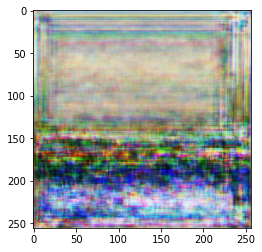

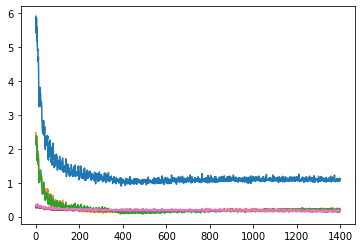

In [20]:
testimg=cv2.imread('guava/00000119.jpg')
testimg=cv2.resize(testimg,dsize=(256,256),interpolation=cv2.INTER_CUBIC)

#testimg=cv2.cvtColor(testimg,cv2.COLOR_BGR2RGB)
testimg=np.array(testimg)/255.0
testimg=np.reshape(testimg,(1,256,256,3))
testout=generator_ab.predict(testimg)

#cv2.imshow('ok',testout)
testout=np.reshape(testout,(256,256,3))
testout=cv2.cvtColor(testout,cv2.COLOR_BGR2RGB)

plt.imshow(testout)
plt.show()
epochs=[]
for i in range(len(glosses)):
  epochs.append(i)
plt.plot(epochs,glosses)
plt.show()

# New Section